In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy
import seaborn as sns
import xlsxwriter

import math
from math import exp, sqrt, log

%matplotlib inline

from scipy import stats


import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.stattools import durbin_watson


import statsmodels.formula.api as smf
import statsmodels.stats.api as sms


import xlsxwriter
#from statsmodels.tsa.ar_model import AR
#from statsmodels.tsa.stattools import grangercausalitytests
#from statsmodels.tsa.tsatools import (lagmat, add_trend)

In [3]:
import eikon
import datetime
 
# Your configuration
app_key = '97c5b917639d4a619467b3cbed7b530d0e625579'  
index = 'STOXX50'
number_of_days = 3650
 
 
# Defines the index RIC and the index chain codes
index_RIC = '.' + index
index_chain = '0#.' + index
 
# Authenticate
eikon.set_app_key(app_key)
 


In [4]:
end = datetime.datetime.now()
start = end - datetime.timedelta(days=number_of_days)


# Read the index into empty dataframe
df_index = eikon.get_timeseries([index_RIC],
                                start_date=start,
                                end_date=end,
                                fields='CLOSE')
 
# Rename "CLOSE" column to the index name to prevent clash
df_index = df_index.rename(columns={'CLOSE': index_RIC})
 
# Read in more stocks
symbols = eikon.get_data(index_chain, 'TR.RIC')[0]['RIC']
 
for symbol in symbols:
    df_temp = eikon.get_timeseries([symbol],
                                   start_date=start,
                                   end_date=end,
                                   fields='CLOSE')
    # Rename to prevent clash
    df_temp = df_temp.rename(columns={'CLOSE': symbol})
 
    # Join the two dataframes
    df_index = df_index.join(df_temp[symbol])
 
# Show the output
print(df_index)

            .STOXX50       BHPB.L  ABBN.S  ADSGn.DE  LINI.DE   BAYGn.DE  \
Date                                                                      
2011-05-12   2637.31  2100.536909   23.32     52.90      NaN  56.969260   
2011-05-13   2619.16  2079.651520   23.19     51.67      NaN  57.284170   
2011-05-16   2619.08  2125.865999   23.24     52.26      NaN  57.471148   
2011-05-17   2594.80  2083.206480   22.98     51.30      NaN  56.093415   
2011-05-18   2606.65  2114.756749   23.05     51.31      NaN  57.018464   
...              ...          ...     ...       ...      ...        ...   
2021-05-03   3402.00          NaN   29.93    259.80    239.6  53.570000   
2021-05-04   3357.93  2196.500000   29.49    252.55    235.7  52.380000   
2021-05-05   3418.10  2306.000000   30.62    259.60    242.5  53.490000   
2021-05-06   3418.96  2314.000000   30.54    258.80    245.5  53.910000   
2021-05-07   3443.78  2337.500000   30.61    280.60    246.4  54.130000   

              SGEF.PA   

In [5]:
df_index.to_excel('raw_data(1).xlsx') #let's save our result as an excel table.However, since everytime we run the previous code, a new timeseries is created, we will use the data saved on 23/04/2021 under 'raw_data.xlsx' for our analysis. 

In [6]:
df_index_raw=pd.read_excel('raw_data.xlsx').set_index('Date')
df_index_raw

,.STOXX50,BHPB.L,ABBN.S,ADSGn.DE,LINI.DE,BAYGn.DE,SGEF.PA,GSK.L,HSBA.L,ADYEN.AS,...,RIO.L,DAIGn.DE,BP.L,PRTP.PA,ALVG.DE,SAF.PA,ENEI.MI,AXAF.PA,ABI.BR,RKT.L
Date,,,,,,,,,,,,,,,,,,,,,
2011-04-29,2661.37,NaN,23.88,50.260,NaN,58.406038,44.656441,NaN,NaN,NaN,...,NaN,52.19,NaN,110.342430,106.30,26.200,4.814,15.150,43.050,NaN
2011-05-02,2660.49,NaN,23.56,50.200,NaN,57.205442,44.423753,NaN,NaN,NaN,...,NaN,52.51,NaN,110.205359,105.90,26.220,4.816,15.160,43.045,NaN
2011-05-03,2651.58,2210.296295,23.01,50.230,NaN,57.618762,44.398999,1297.516780,662.50,NaN,...,4025.460406,51.65,457.95,111.119168,106.35,26.000,4.804,15.215,42.860,3341.734019
2011-05-04,2614.84,2152.083828,22.86,49.885,NaN,56.477212,43.755391,1288.150208,651.80,NaN,...,3893.701015,50.74,448.70,110.022597,104.70,25.555,4.730,14.995,41.450,3330.005207
2011-05-05,2608.68,2120.089189,22.60,53.500,NaN,57.057828,43.463293,1291.601050,646.20,NaN,...,3832.744713,50.65,441.05,109.245860,100.45,25.350,4.706,15.025,40.700,3327.073004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-19,3412.00,2217.500000,30.44,277.200,239.20,54.960000,92.080000,1338.000000,428.10,1996.2,...,6089.000000,75.96,300.85,640.200000,219.10,122.400,8.662,23.750,57.060,6705.000000
2021-04-20,3350.45,2167.000000,29.73,269.100,237.45,54.140000,87.950000,1325.200000,417.25,1981.0,...,5955.000000,73.69,291.75,626.100000,215.55,117.200,8.555,23.170,55.730,6676.000000
2021-04-21,3386.11,2178.500000,29.82,271.550,241.65,55.850000,87.420000,1348.000000,415.85,2012.5,...,5974.000000,73.57,295.70,652.200000,216.20,117.040,8.487,23.170,57.780,6783.000000


In [7]:
df_index_raw.shape #The 50 consitutents in addition to the index 

(2562, 51)

In [8]:
for col in df_index_raw.iteritems():
    print('plotting'+col[0])
    fig, ax = plt.subplots()
    indicator=df_index_raw[col[0]]
    ax.plot(indicator, alpha=0.9, color='blue')
    plt.title(col[0])
    plt.savefig('Charts_AQM_'+col[0]+'.png')
    plt.close()

plotting.STOXX50
plottingBHPB.L
plottingABBN.S
plottingADSGn.DE
plottingLINI.DE
plottingBAYGn.DE
plottingSGEF.PA
plottingGSK.L
plottingHSBA.L
plottingADYEN.AS
plottingULVR.L
plottingBNPP.PA
plottingAIR.PA
plottingNESN.S
plottingTOTF.PA
plottingNOVN.S
plottingAIRP.PA
plottingLVMH.PA
plottingASML.AS
plottingSASY.PA
plottingNOVOb.CO
plottingIBE.MC
plottingISP.MI
plottingRDSa.AS
plottingROG.S
plottingUBSG.S
plottingBATS.L
plottingDGE.L
plottingREL.L
plottingAZN.L
plottingPRU.L
plottingVOD.L
plottingOREP.PA
plottingSIEGn.DE
plottingSAPG.DE
plottingZURN.S
plottingSCHN.PA
plottingBASFn.DE
plottingNG.L
plottingPRX.AS
plottingDTEGn.DE
plottingRIO.L
plottingDAIGn.DE
plottingBP.L
plottingPRTP.PA
plottingALVG.DE
plottingSAF.PA
plottingENEI.MI
plottingAXAF.PA
plottingABI.BR
plottingRKT.L


# Missing value, Cleaning data

In [9]:
df_index_raw.isnull().sum()  #let's indentify the misisng values per column

.STOXX50       0
BHPB.L        38
ABBN.S        58
ADSGn.DE      34
LINI.DE     1704
BAYGn.DE      34
SGEF.PA        8
GSK.L         38
HSBA.L        38
ADYEN.AS    1830
ULVR.L        38
BNPP.PA        8
AIR.PA         8
NESN.S        58
TOTF.PA        8
NOVN.S        58
AIRP.PA        8
LVMH.PA        8
ASML.AS        8
SASY.PA        8
NOVOb.CO      71
IBE.MC         8
ISP.MI        30
RDSa.AS        8
ROG.S         58
UBSG.S        58
BATS.L        38
DGE.L         38
REL.L         38
AZN.L         38
PRU.L         38
VOD.L         38
OREP.PA        8
SIEGn.DE      34
SAPG.DE       34
ZURN.S        58
SCHN.PA        8
BASFn.DE      34
NG.L          38
PRX.AS      2149
DTEGn.DE      34
RIO.L         38
DAIGn.DE      34
BP.L          38
PRTP.PA        8
ALVG.DE       34
SAF.PA         8
ENEI.MI       30
AXAF.PA        8
ABI.BR         8
RKT.L         38
dtype: int64

In [10]:
df_index_updated=df_index_raw.drop(axis=1,columns=['LINI.DE','ADYEN.AS','PRX.AS'])

# Fill the missing data

In [11]:
df_index_updated

,.STOXX50,BHPB.L,ABBN.S,ADSGn.DE,BAYGn.DE,SGEF.PA,GSK.L,HSBA.L,ULVR.L,BNPP.PA,...,RIO.L,DAIGn.DE,BP.L,PRTP.PA,ALVG.DE,SAF.PA,ENEI.MI,AXAF.PA,ABI.BR,RKT.L
Date,,,,,,,,,,,,,,,,,,,,,
2011-04-29,2661.37,NaN,23.88,50.260,58.406038,44.656441,NaN,NaN,NaN,53.43,...,NaN,52.19,NaN,110.342430,106.30,26.200,4.814,15.150,43.050,NaN
2011-05-02,2660.49,NaN,23.56,50.200,57.205442,44.423753,NaN,NaN,NaN,53.39,...,NaN,52.51,NaN,110.205359,105.90,26.220,4.816,15.160,43.045,NaN
2011-05-03,2651.58,2210.296295,23.01,50.230,57.618762,44.398999,1297.516780,662.50,1987.0,53.45,...,4025.460406,51.65,457.95,111.119168,106.35,26.000,4.804,15.215,42.860,3341.734019
2011-05-04,2614.84,2152.083828,22.86,49.885,56.477212,43.755391,1288.150208,651.80,1973.0,54.05,...,3893.701015,50.74,448.70,110.022597,104.70,25.555,4.730,14.995,41.450,3330.005207
2011-05-05,2608.68,2120.089189,22.60,53.500,57.057828,43.463293,1291.601050,646.20,1951.0,53.98,...,3832.744713,50.65,441.05,109.245860,100.45,25.350,4.706,15.025,40.700,3327.073004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-19,3412.00,2217.500000,30.44,277.200,54.960000,92.080000,1338.000000,428.10,4132.0,53.33,...,6089.000000,75.96,300.85,640.200000,219.10,122.400,8.662,23.750,57.060,6705.000000
2021-04-20,3350.45,2167.000000,29.73,269.100,54.140000,87.950000,1325.200000,417.25,4128.0,50.83,...,5955.000000,73.69,291.75,626.100000,215.55,117.200,8.555,23.170,55.730,6676.000000
2021-04-21,3386.11,2178.500000,29.82,271.550,55.850000,87.420000,1348.000000,415.85,4139.5,50.36,...,5974.000000,73.57,295.70,652.200000,216.20,117.040,8.487,23.170,57.780,6783.000000


In [12]:
df_index_cleaned=df_index_updated.fillna(method='backfill') #save the cleaned dataset into an excel table

In [13]:
df_index_cleaned.head()

,.STOXX50,BHPB.L,ABBN.S,ADSGn.DE,BAYGn.DE,SGEF.PA,GSK.L,HSBA.L,ULVR.L,BNPP.PA,...,RIO.L,DAIGn.DE,BP.L,PRTP.PA,ALVG.DE,SAF.PA,ENEI.MI,AXAF.PA,ABI.BR,RKT.L
Date,,,,,,,,,,,,,,,,,,,,,
2011-04-29,2661.37,2210.296295,23.88,50.260,58.406038,44.656441,1297.516780,662.5,1987.0,53.43,...,4025.460406,52.19,457.95,110.342430,106.30,26.200,4.814,15.150,43.050,3341.734019
2011-05-02,2660.49,2210.296295,23.56,50.200,57.205442,44.423753,1297.516780,662.5,1987.0,53.39,...,4025.460406,52.51,457.95,110.205359,105.90,26.220,4.816,15.160,43.045,3341.734019
2011-05-03,2651.58,2210.296295,23.01,50.230,57.618762,44.398999,1297.516780,662.5,1987.0,53.45,...,4025.460406,51.65,457.95,111.119168,106.35,26.000,4.804,15.215,42.860,3341.734019
2011-05-04,2614.84,2152.083828,22.86,49.885,56.477212,43.755391,1288.150208,651.8,1973.0,54.05,...,3893.701015,50.74,448.70,110.022597,104.70,25.555,4.730,14.995,41.450,3330.005207
2011-05-05,2608.68,2120.089189,22.60,53.500,57.057828,43.463293,1291.601050,646.2,1951.0,53.98,...,3832.744713,50.65,441.05,109.245860,100.45,25.350,4.706,15.025,40.700,3327.073004


In [14]:
df_index_cleaned.to_excel('df_index_cleaned.xlsx') 

In [15]:
df_index=pd.read_excel('df_index_cleaned.xlsx') #we are renaming our df_index_cleaned for df_index in order to save time

In [16]:
df_index.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2562 entries, 0 to 2561
Data columns (total 49 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      2562 non-null   datetime64[ns]
 1   .STOXX50  2562 non-null   float64       
 2   BHPB.L    2562 non-null   float64       
 3   ABBN.S    2562 non-null   float64       
 4   ADSGn.DE  2562 non-null   float64       
 5   BAYGn.DE  2562 non-null   float64       
 6   SGEF.PA   2562 non-null   float64       
 7   GSK.L     2562 non-null   float64       
 8   HSBA.L    2562 non-null   float64       
 9   ULVR.L    2562 non-null   float64       
 10  BNPP.PA   2562 non-null   float64       
 11  AIR.PA    2562 non-null   float64       
 12  NESN.S    2562 non-null   float64       
 13  TOTF.PA   2562 non-null   float64       
 14  NOVN.S    2562 non-null   float64       
 15  AIRP.PA   2562 non-null   float64       
 16  LVMH.PA   2562 non-null   float64       
 17  ASML.AS   2562

# Comparison with Excel database

In [17]:
df_index_excel=pd.read_excel('3.Excel_Data.xlsx')
df_index_excel.head(10)

,Date,.STOXX50,ABBN.S,ABI.BR,ADSGn.DE,ADYEN.AS,AIR.PA,AIRP.PA,ALVG.DE,ASML.AS,...,SAPG.DE,SASY.PA,SCHN.PA,SGEF.PA,SIEGn.DE,TOTF.PA,UBSG.S,ULVR.L,VOD.L,ZURN.S
0,NaT,TRDPRC_1,TRDPRC_1,TRDPRC_1,OFF_CLOSE,TRDPRC_1,TRDPRC_1,TRDPRC_1,OFF_CLOSE,TRDPRC_1,...,OFF_CLOSE,TRDPRC_1,TRDPRC_1,TRDPRC_1,OFF_CLOSE,TRDPRC_1,TRDPRC_1,TRDPRC_1,TRDPRC_1,TRDPRC_1
1,2011-04-29,2661.37,23.88,43.05,50.26,NaN,20.89,66.2936,106.3,28.8325,...,43.5,53.4,59.65,44.6564,85.7995,43.22,17.29,NaN,NaN,243
2,2011-05-02,2660.49,23.56,43.045,50.2,NaN,20.77,66.3733,105.9,28.8273,...,43.915,53.88,59.35,44.4238,85.4588,43.045,17.1,NaN,NaN,244.4
3,2011-05-03,2651.58,23.01,42.86,50.23,NaN,20.75,66.1078,106.35,28.8015,...,43.745,53.9,58.925,44.399,85.0744,42.76,17.06,1987,172.71,244
4,2011-05-04,2614.84,22.86,41.45,49.885,NaN,20.47,64.3422,104.7,28.9459,...,43.2,54.32,57.475,43.7554,82.6547,41.765,17.04,1973.04,169.703,243.5
5,2011-05-05,2608.68,22.6,40.7,53.5,NaN,20.4,64.7006,100.45,29.1522,...,42.97,54.05,57.15,43.4633,82.8119,41.175,16.74,1950.06,169.797,235.1
6,2011-05-06,2640.23,23.08,41.29,52.88,NaN,20.95,65.7427,101.85,29.2089,...,43.39,55.21,58.4,44.1564,83.8165,41.61,17.03,1979.08,168.109,235.2
7,2011-05-09,2627.28,22.96,41.13,52.92,NaN,20.97,65.0325,99.45,29.539,...,43.69,54.96,57.25,43.493,82.8643,41.27,16.7,1971.26,170.264,231.3
8,2011-05-10,2647.65,23.36,41.195,53.06,NaN,21.515,65.8821,101,29.8793,...,44.26,55.01,57.75,44.2703,83.8864,41.81,16.88,1971.9,170.515,234.4
9,2011-05-11,2653.45,23.36,40.89,52.77,NaN,21.76,63.8643,101.65,28.8583,...,44.615,55.84,57.775,44.4634,83.8514,41.525,16.82,1975,169.964,235.2


In [18]:
df_index_excel.shape

(2617, 52)

In [19]:
df_index_excel.isnull().sum()

Date           1
.STOXX50       0
ABBN.S         0
ABI.BR         0
ADSGn.DE       0
ADYEN.AS    1865
AIR.PA         0
AIRP.PA        0
ALVG.DE        0
ASML.AS        0
AXAF.PA        0
AZN.L          2
BASFn.DE       0
BATS.L         2
BAYGn.DE       0
BHPB.L         2
BNPP.PA        0
BP.L           2
DAIGn.DE       0
DGE.L          2
DTEGn.DE       0
ENEI.MI        0
GSK.L          2
HSBA.L         2
IBE.MC         0
ISP.MI         0
LINI.DE     1721
LVMH.PA        0
NESN.S         0
NG.L           2
NOVN.S         0
NOVOb.CO       0
OREP.PA        0
PRTP.PA        0
PRU.L          2
PRX.AS      2191
RDSa.AS        0
REL.L          2
RIO.L          2
RKT.L          2
ROG.S          0
SAF.PA         0
SAPG.DE        0
SASY.PA        0
SCHN.PA        0
SGEF.PA        0
SIEGn.DE       0
TOTF.PA        0
UBSG.S         0
ULVR.L         2
VOD.L          2
ZURN.S         0
dtype: int64

In [20]:
df_index_excel=df_index_excel.fillna(method='backfill')
df_index_excel

,Date,.STOXX50,ABBN.S,ABI.BR,ADSGn.DE,ADYEN.AS,AIR.PA,AIRP.PA,ALVG.DE,ASML.AS,...,SAPG.DE,SASY.PA,SCHN.PA,SGEF.PA,SIEGn.DE,TOTF.PA,UBSG.S,ULVR.L,VOD.L,ZURN.S
0,2011-04-29,TRDPRC_1,TRDPRC_1,TRDPRC_1,OFF_CLOSE,TRDPRC_1,TRDPRC_1,TRDPRC_1,OFF_CLOSE,TRDPRC_1,...,OFF_CLOSE,TRDPRC_1,TRDPRC_1,TRDPRC_1,OFF_CLOSE,TRDPRC_1,TRDPRC_1,TRDPRC_1,TRDPRC_1,TRDPRC_1
1,2011-04-29,2661.37,23.88,43.05,50.26,455,20.89,66.2936,106.3,28.8325,...,43.5,53.4,59.65,44.6564,85.7995,43.22,17.29,1987,172.71,243
2,2011-05-02,2660.49,23.56,43.045,50.2,455,20.77,66.3733,105.9,28.8273,...,43.915,53.88,59.35,44.4238,85.4588,43.045,17.1,1987,172.71,244.4
3,2011-05-03,2651.58,23.01,42.86,50.23,455,20.75,66.1078,106.35,28.8015,...,43.745,53.9,58.925,44.399,85.0744,42.76,17.06,1987,172.71,244
4,2011-05-04,2614.84,22.86,41.45,49.885,455,20.47,64.3422,104.7,28.9459,...,43.2,54.32,57.475,43.7554,82.6547,41.765,17.04,1973.04,169.703,243.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2612,2021-04-19,3412,30.44,57.06,277.2,1996.2,102.7,141.08,219.1,522.2,...,116.04,86.21,137.52,92.08,143.8,38.04,14.605,4132,135.905,382.5
2613,2021-04-20,3350.45,29.73,55.73,269.1,1981,97.94,139.68,215.55,512,...,115.34,86.06,136.14,87.95,140.28,36.86,14.22,4128,131.48,377.8
2614,2021-04-21,3386.11,29.82,57.78,271.55,2012.5,97.73,140.58,216.2,532.9,...,116.7,86.84,135.32,87.42,141.2,36.905,14.055,4139.5,132.84,378.4
2615,2021-04-22,3407.58,29.75,58.67,270.3,2072.5,99.71,141.34,216.05,543.7,...,120.7,86.55,137.12,86.96,142.46,36.895,13.975,4126.5,133.2,375.5


In [21]:
df_index_excel.isnull().sum()

Date        0
.STOXX50    0
ABBN.S      0
ABI.BR      0
ADSGn.DE    0
ADYEN.AS    0
AIR.PA      0
AIRP.PA     0
ALVG.DE     0
ASML.AS     0
AXAF.PA     0
AZN.L       0
BASFn.DE    0
BATS.L      0
BAYGn.DE    0
BHPB.L      0
BNPP.PA     0
BP.L        0
DAIGn.DE    0
DGE.L       0
DTEGn.DE    0
ENEI.MI     0
GSK.L       0
HSBA.L      0
IBE.MC      0
ISP.MI      0
LINI.DE     0
LVMH.PA     0
NESN.S      0
NG.L        0
NOVN.S      0
NOVOb.CO    0
OREP.PA     0
PRTP.PA     0
PRU.L       0
PRX.AS      0
RDSa.AS     0
REL.L       0
RIO.L       0
RKT.L       0
ROG.S       0
SAF.PA      0
SAPG.DE     0
SASY.PA     0
SCHN.PA     0
SGEF.PA     0
SIEGn.DE    0
TOTF.PA     0
UBSG.S      0
ULVR.L      0
VOD.L       0
ZURN.S      0
dtype: int64

In [22]:
df_index_excel.to_excel('4.df_index_excel_cleaned.xlsx')

# Download the data to SQL 

In [190]:
import sqlite3

from sqlite3 import Error
 

""" create a database connection tool to a SQLite database """

def create_connection(db_file): #not necessary but handles the errors
    conn = None
    try:
        conn = sqlite3.connect(db_file) #tries to connect through the library and if it works, it prints the version of the sql used
        print(sqlite3.version)
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()
 
 
if __name__ == '__main__':
    create_connection('df_index.db')


conn = sqlite3.connect('df_index.db')
c = conn.cursor()
print('Opened database successfully')


2.6.0
Opened database successfully


In [24]:
conn = sqlite3.connect('df_index.db')
c = conn.cursor()
conn.execute('''CREATE TABLE STOXX_50
         (DATE TIMESTAMP,
         STOXX50          INT    NOT NULL,
         BHPBL            INT    NOT NULL,
         ABBNS            INT    NOT NULL,
         ADSGnDE          INT    NOT NULL,
         LINIDE           INT    NOT NULL,
         BAYGnDE          INT    NOT NULL,
         SGEFPA           INT    NOT NULL,
         GSKL             INT    NOT NULL,
         HSBAL            INT    NOT NULL, 
         ADYENAS          INT    NOT NULL,
         ULVRL            INT    NOT NULL,
         BNPPPA           INT    NOT NULL,
         AIRPA            INT    NOT NULL,
         NESNS            INT    NOT NULL,
         TOTFPA           INT    NOT NULL,
         NOVNS            INT    NOT NULL,
         AIRPPA           INT    NOT NULL,
         LVMHPA           INT    NOT NULL,
         ASMLAS           INT    NOT NULL,
         SASYPA           INT    NOT NULL,
         NOVObCO          INT    NOT NULL,
         IBEMC            INT    NOT NULL,
         ISPM             INT    NOT NULL,
         RDSaAS           INT    NOT NULL,
         ROGS             INT    NOT NULL,
         UBSGS            INT    NOT NULL,
         BATSL            INT    NOT NULL,
         DGEL             INT    NOT NULL,
         RELL             INT    NOT NULL,
         AZNL             INT    NOT NULL,
         PRUL             INT    NOT NULL,
         VODL             INT    NOT NULL,
         OREPPA           INT    NOT NULL,
         SIEGnDE          INT    NOT NULL,
         SAPGDE           INT    NOT NULL,
         ZURNS            INT    NOT NULL,
         SCHNPA           INT    NOT NULL,
         BASFnDE          INT    NOT NULL,
         NGL              INT    NOT NULL,
         PRXAS            INT    NOT NULL,
         DTEGnDE          INT    NOT NULL,
         RIOL             INT    NOT NULL,
         DAIGnDE          INT    NOT NULL,
         BPL              INT    NOT NULL,
         PRTPPA           INT    NOT NULL,
         ALVGDE           INT    NOT NULL,
         SAFPA            INT    NOT NULL,
         ENEIMI           INT    NOT NULL,
         AXAFPA           INT    NOT NULL,
         ABIBR            INT    NOT NULL,
         RKTL INT)''')

print("Table created successfully")

OperationalError: table STOXX_50 already exists

In [ ]:
index1=df_index.index.strftime('%Y-%m-%d %H-%M-%S')
df_index['Date']=index1
df_index.head(5)

In [ ]:
df_index.shape

In [ ]:
# convert data from dataframe into a vector of lists

records_to_insert = df_index.values.tolist()
records_to_insert

In [ ]:
#Let's insert data into our dataframe

c = conn.cursor()
c.executemany("INSERT INTO STOXX_50(STOXX50,BHPBL,ABBNS,ADSGnDE,LINIDE,BAYGnDE,SGEFPA,GSKL,HSBAL,ADYENAS,ULVRL,BNPPPA,AIRPA,NESNS,TOTFPA,NOVNS,AIRPPA,LVMHPA,ASMLAS,SASYPA,NOVObCO,IBEMC,ISPM,RDSaAS,ROGS,UBSGS,BATSL,DGEL,RELL,AZNL,PRUL,VODL,OREPPA,SIEGnDE,SAPGDE,ZURNS,SCHNPA,BASFnDE,NGL,PRXAS,DTEGnDE,RIOL,DAIGnDE,BPL,PRTPPA,ALVGDE,SAFPA,ENEIMI,AXAFPA,ABIBR,RKTL,DATE) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)", records_to_insert)    
conn.commit()

In [ ]:
#Let's now select the data from the database and pull them to python 
c = conn.cursor()
c.execute("SELECT * FROM STOXX_50")
new_data=c.fetchall()
new_data

# Analysis 

In [ ]:
df_index.describe() #the basic distribution analysis for prices 

# Analysis:Returns

In [55]:
#get returns 
df_index_analysis=df_index[['.STOXX50','BHPB.L', 'ABBN.S', 'ADSGn.DE', 'BAYGn.DE',
       'SGEF.PA', 'GSK.L', 'HSBA.L', 'ULVR.L', 'BNPP.PA', 'AIR.PA',
       'NESN.S', 'TOTF.PA', 'NOVN.S', 'AIRP.PA', 'LVMH.PA', 'ASML.AS',
       'SASY.PA', 'NOVOb.CO', 'IBE.MC', 'ISP.MI', 'RDSa.AS', 'ROG.S', 'UBSG.S',
       'BATS.L', 'DGE.L', 'REL.L', 'AZN.L', 'PRU.L', 'VOD.L', 'OREP.PA',
       'SIEGn.DE', 'SAPG.DE', 'ZURN.S', 'SCHN.PA', 'BASFn.DE', 'NG.L','DTEGn.DE', 'RIO.L', 'DAIGn.DE', 'BP.L', 'PRTP.PA', 'ALVG.DE',
       'SAF.PA', 'ENEI.MI', 'AXAF.PA', 'ABI.BR', 'RKT.L']].pct_change()

df_index_analysis1=df_index_analysis[['.STOXX50','BHPB.L', 'ABBN.S', 'ADSGn.DE', 'BAYGn.DE',
       'SGEF.PA', 'GSK.L', 'HSBA.L', 'ULVR.L', 'BNPP.PA', 'AIR.PA',
       'NESN.S', 'TOTF.PA', 'NOVN.S', 'AIRP.PA', 'LVMH.PA', 'ASML.AS',
       'SASY.PA', 'NOVOb.CO', 'IBE.MC', 'ISP.MI', 'RDSa.AS', 'ROG.S', 'UBSG.S',
       'BATS.L', 'DGE.L', 'REL.L', 'AZN.L', 'PRU.L', 'VOD.L', 'OREP.PA',
       'SIEGn.DE', 'SAPG.DE', 'ZURN.S', 'SCHN.PA', 'BASFn.DE', 'NG.L',
       'DTEGn.DE', 'RIO.L', 'DAIGn.DE', 'BP.L', 'PRTP.PA', 'ALVG.DE',
       'SAF.PA', 'ENEI.MI', 'AXAF.PA', 'ABI.BR', 'RKT.L']]

df_index_analysis1.to_excel('5.df_returns.xlsx')

In [56]:
df_index_analysis1

,.STOXX50,BHPB.L,ABBN.S,ADSGn.DE,BAYGn.DE,SGEF.PA,GSK.L,HSBA.L,ULVR.L,BNPP.PA,...,RIO.L,DAIGn.DE,BP.L,PRTP.PA,ALVG.DE,SAF.PA,ENEI.MI,AXAF.PA,ABI.BR,RKT.L
Date,,,,,,,,,,,,,,,,,,,,,
2011-04-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-05-02,-0.000331,0.000000,-0.013400,-0.001194,-0.020556,-0.005211,0.000000,0.000000,0.000000,-0.000749,...,0.000000,0.006131,0.000000,-0.001242,-0.003763,0.000763,0.000415,0.000660,-0.000116,0.000000
2011-05-03,-0.003349,0.000000,-0.023345,0.000598,0.007225,-0.000557,0.000000,0.000000,0.000000,0.001124,...,0.000000,-0.016378,0.000000,0.008292,0.004249,-0.008391,-0.002492,0.003628,-0.004298,0.000000
2011-05-04,-0.013856,-0.026337,-0.006519,-0.006868,-0.019812,-0.014496,-0.007219,-0.016151,-0.007046,0.011225,...,-0.032732,-0.017619,-0.020199,-0.009868,-0.015515,-0.017115,-0.015404,-0.014459,-0.032898,-0.003510
2011-05-05,-0.002356,-0.014867,-0.011374,0.072467,0.010281,-0.006676,0.002679,-0.008592,-0.011151,-0.001295,...,-0.015655,-0.001774,-0.017049,-0.007060,-0.040592,-0.008022,-0.005074,0.002001,-0.018094,-0.000881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-19,-0.001507,-0.009824,-0.008146,-0.002519,0.017778,0.015775,-0.006239,0.001521,-0.007685,0.008129,...,0.005781,-0.018478,-0.006932,0.008189,0.001600,-0.004068,0.000346,0.001898,0.005108,0.006606
2021-04-20,-0.018039,-0.022773,-0.023325,-0.029221,-0.014920,-0.044852,-0.009567,-0.025345,-0.000968,-0.046878,...,-0.022007,-0.029884,-0.030248,-0.022024,-0.016203,-0.042484,-0.012353,-0.024421,-0.023309,-0.004325
2021-04-21,0.010643,0.005307,0.003027,0.009104,0.031585,-0.006026,0.017205,-0.003355,0.002786,-0.009247,...,0.003191,-0.001628,0.013539,0.041687,0.003016,-0.001365,-0.007949,0.000000,0.036784,0.016028


In [ ]:
for col in df_index_analysis1.iteritems():
    print('plotting'+col[0])
    fig, ax = plt.subplots()
    indicator=df_index_analysis1[col[0]]
    ax.plot(indicator, alpha=0.9, color='blue')
    plt.title(col[0])
    plt.savefig('Charts_AQM_returns'+col[0]+'.png')
    plt.close()

# Analysis: Outlier identification

# BNPP.PA

In [ ]:
#Is there outliers in the ABBN.S security
df_index_analysis1['BNPP.PA'].plot()

In [ ]:
#OLS analysis
y = df_index_analysis1['.STOXX50'][1:]  #we are excluding the first line of the returns because it is empty (pct.change)
x = df_index_analysis1[ 'BNPP.PA'][1:]
x = sm.add_constant(x)
model = sm.OLS(y,x) 
results1 = model.fit(cov_type='HC0') #HC0 method is robust for Heteroskedasticity
print(results1.summary())



In [ ]:
#Save the regression tab
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(results1.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('output_OLS_BNPP.PA.png')

In [ ]:
regression1 = pd.DataFrame(y)



prediction = results1.predict()



regression1['Prediction']=prediction
regression1.plot()

In [ ]:
regression1['Diff']=regression1['Prediction']-regression1['.STOXX50']
regression1

In [ ]:
regression1['Diff'].mean()

In [ ]:
#scatter plot vs prediction
from sklearn.linear_model import LinearRegression
X=df_index_analysis1.iloc[1:,10].values.reshape(-1,1) #creates an array
Y=df_index_analysis1.iloc[1:,0].values.reshape(-1,1)

lr=LinearRegression()
lr.fit(X,Y)
Y_pred=lr.predict(X)
plt.scatter(X,Y)
plt.plot(X,Y_pred,color='red')
plt.show()


In [ ]:
df_index_analysis1['BNPP.PA'][(df_index_analysis1['BNPP.PA']>=0.10)|(df_index_analysis1['BNPP.PA']<=-0.10)]

In [ ]:
df_index_analysis['BNPP.PA'][(df_index_analysis['BNPP.PA']>=0.10)|(df_index_analysis['BNPP.PA']<=-0.10)].index

In [ ]:
df_trial=df_index_analysis1.drop(df_index_analysis1.index[[96, 99, 107, 129, 132, 151, 1323, 2273, 2276, 2278, 2446]],axis=0)


In [ ]:
from sklearn.linear_model import LinearRegression
X=df_trial.iloc[1:,10].values.reshape(-1,1) #creates an array
Y=df_trial.iloc[1:,0].values.reshape(-1,1)

lr=LinearRegression()
lr.fit(X,Y)
Y_pred=lr.predict(X)
plt.scatter(X,Y)
plt.plot(X,Y_pred,color='red')
plt.show()


#

In [ ]:
y = df_trial['.STOXX50'][1:]
x = df_trial[ 'BNPP.PA'][1:]
x = sm.add_constant(x)
model = sm.OLS(y,x) 
results2 = model.fit(cov_type='HC0')
print(results2.summary())


In [ ]:
#Save the regression tab
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(results2.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('output_OLS(w.o. outliers)_BNPP.PA.png')

In [ ]:
regression2 = pd.DataFrame(y)

prediction = results2.predict()



regression2['Prediction']=prediction
regression2.plot()

# Airbus

In [ ]:
#Is there outliers in the ABBN.S security
df_index_analysis1['AIR.PA'].plot()

In [ ]:
#OLS
y = df_index_analysis1['.STOXX50'][1:]
x = df_index_analysis1[ 'AIR.PA'][1:]
x = sm.add_constant(x)
model = sm.OLS(y,x) 
results3 = model.fit(cov_type='HC0')
print(results3.summary())


In [ ]:
#Save the regression tab
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(results3.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('output_OLS_AIR.PA.png')

In [ ]:
#scatter plot vs prediction
from sklearn.linear_model import LinearRegression
X=df_index_analysis1.iloc[1:,11].values.reshape(-1,1) #creates an array
Y=df_index_analysis1.iloc[1:,0].values.reshape(-1,1)

lr=LinearRegression()
lr.fit(X,Y)
Y_pred=lr.predict(X)
plt.scatter(X,Y)
plt.plot(X,Y_pred,color='red')
plt.show()


In [ ]:
df_index_analysis1['AIR.PA'][(df_index_analysis1['AIR.PA']>=0.10)|(df_index_analysis1['AIR.PA']<=-0.10)]

df_index_analysis['AIR.PA'][(df_index_analysis['AIR.PA']>=0.10)|(df_index_analysis['AIR.PA']<=-0.10)].index

In [ ]:
df_trial=df_index_analysis1.drop(df_index_analysis1.index[[223,  356,  930, 1746, 2276, 2280, 2282, 2283, 2286, 2288, 2290,
            2308, 2321, 2335, 2339, 2446]],axis=0)

In [ ]:
#OLS without ouliers
y = df_trial['.STOXX50'][1:]
x = df_trial[ 'AIR.PA'][1:]
x = sm.add_constant(x)
model = sm.OLS(y,x) 
results4 = model.fit(cov_type='HC0')
print(results4.summary())




regression4= pd.DataFrame(y)



prediction = results4.predict()



regression4['Prediction']=prediction
regression4.plot()



In [ ]:
#Save the regression tab
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(results4.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('output_OLS(w.o. outliers)_AIR.PA.png')

In [ ]:
#scatter plot vs prediction
from sklearn.linear_model import LinearRegression
X=df_trial.iloc[1:,11].values.reshape(-1,1) #creates an array
Y=df_trial.iloc[1:,0].values.reshape(-1,1)

lr=LinearRegression()
lr.fit(X,Y)
Y_pred=lr.predict(X)
plt.scatter(X,Y)
plt.plot(X,Y_pred,color='red')
plt.show()

df_index_analysis1.describe()
df_trial.describe()

# SAPG.DE

In [ ]:
#is there any outliers? 
df_index_analysis1['SAPG.DE'].plot()



#OLS
y = df_index_analysis1['.STOXX50'][1:]
x = df_index_analysis1[ 'SAPG.DE'][1:]
x = sm.add_constant(x)
model = sm.OLS(y,x) 
results5 = model.fit(cov_type='HC0')
print(results5.summary())


regression5= pd.DataFrame(y)



prediction = results5.predict()



regression5['Prediction']=prediction
regression5.plot()






In [ ]:
#Save the regression tab
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(results5.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('output_OLS_SAPG.DE.png')

In [ ]:
#scatter plot vs prediction
from sklearn.linear_model import LinearRegression
X=df_index_analysis1.iloc[1:,33].values.reshape(-1,1) #creates an array
Y=df_index_analysis1.iloc[1:,0].values.reshape(-1,1)

lr=LinearRegression()
lr.fit(X,Y)
Y_pred=lr.predict(X)
plt.scatter(X,Y)
plt.plot(X,Y_pred,color='red')
plt.show()

df_index_analysis['SAPG.DE'][(df_index_analysis['SAPG.DE']>=0.10)|(df_index_analysis['SAPG.DE']<=-0.10)].index


In [ ]:
df_trial=df_index_analysis1.drop(df_index_analysis1.index[[2048, 2170, 2436]],axis=0)
#OLS without ouliers
y = df_trial['.STOXX50'][1:]
x = df_trial[ 'SAPG.DE'][1:]
x = sm.add_constant(x)
model = sm.OLS(y,x) 
results6 = model.fit(cov_type='HC0')
print(results6.summary())


regression6= pd.DataFrame(y)



prediction = results6.predict()



regression6['Prediction']=prediction
regression6.plot()



In [ ]:
#Save the regression tab
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(results6.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('output_OLS(w.o. outliers)_SAPG.DE.png')

In [ ]:
#scatter plot vs prediction
from sklearn.linear_model import LinearRegression
X=df_trial.iloc[1:,11].values.reshape(-1,1) #creates an array
Y=df_trial.iloc[1:,0].values.reshape(-1,1)

lr=LinearRegression()
lr.fit(X,Y)
Y_pred=lr.predict(X)
plt.scatter(X,Y)
plt.plot(X,Y_pred,color='red')
plt.show()

df_index_analysis1.describe()
df_trial.describe()

# Analysis

# MULTIPLE OLS

In [25]:
def OLS(y,x):

    #if const is not None: x['const']=1
        
    #Beta estimates [(X'X)^-1]X'Y
    x_xt= np.dot(x.T,x)        # multiply vector X with transposed vector X'
    x_x_inv= np.linalg.inv(x_xt)   # invert the matrix

    x_y= np.dot(x.T,y)              # multiply transposed vector X' with Y
    est_betas=  np.dot(x_x_inv,x_y) # multiply (X'X)^-1 with X'Y
    est_Y= np.dot(est_betas,x.T)    # multiply est_betas with X'
        
    nb_obs=x.shape[0]  
    rank=x.shape[1] #equals p = number of regressors 
    deg_freedom_residual=nb_obs-rank
    
    #Y estimate
    est_y = np.dot(x,est_betas)
    est_resid = y-est_y
    
    est_resid_2 = np.dot(est_resid.T,est_resid)
    
    est_sigma_2= est_resid_2 / nb_obs
    
    est_var_covar_beta = np.dot(x_x_inv,est_sigma_2)  #Variance-Covariance Matrix of Betas
        #var_beta_est = np.kron(x_x_inv,est_sigma_2) #???
    
    est_var_beta = np.diag(est_var_covar_beta)
    est_sd_beta=np.sqrt(est_var_beta)    # standard errors
    t_stats= est_betas/est_sd_beta       # t-stats
    pvals = stats.t.sf(np.abs(t_stats), nb_obs-1)*2
  
    SST=np.var(y)*nb_obs
    SSR=est_resid_2
    R_2=1-(SSR/SST)
    
    llf = (-0.5*nb_obs * np.log(2 * np.pi*est_sigma_2)) -(0.5*nb_obs*(1/np.log(est_sigma_2))*est_resid_2)
    
    OLS_results = {
        'Y': y,
        'est_Y': est_Y,
        'X': x,
        'est_betas': est_betas,
        'est_resid': est_resid,
        'nb_obs': nb_obs,
        'deg_freedom_residual': deg_freedom_residual,
        'est_sigma_2': est_sigma_2,
        'est_var_covar_beta': est_var_covar_beta,
        't_stats': t_stats,
        'pvals': pvals,
        'llf': llf,
        'nb_parms': rank,
        'R_2': R_2
    }
                                                          
    return OLS_results

# Test for Prediction's validity

In [57]:
y = df_index_analysis1['.STOXX50'].dropna()
x = df_index_analysis1[['BHPB.L', 'ABBN.S', 'ADSGn.DE', 'BAYGn.DE',
       'SGEF.PA', 'GSK.L', 'HSBA.L', 'ULVR.L', 'BNPP.PA', 'AIR.PA',
       'NESN.S', 'TOTF.PA', 'NOVN.S', 'AIRP.PA', 'LVMH.PA', 'ASML.AS',
       'SASY.PA', 'NOVOb.CO', 'IBE.MC', 'ISP.MI', 'RDSa.AS', 'ROG.S', 'UBSG.S',
       'BATS.L', 'DGE.L', 'REL.L', 'AZN.L', 'PRU.L', 'VOD.L', 'OREP.PA',
       'SIEGn.DE', 'SAPG.DE', 'ZURN.S', 'SCHN.PA', 'BASFn.DE', 'NG.L',
       'DTEGn.DE', 'RIO.L', 'DAIGn.DE', 'BP.L', 'PRTP.PA', 'ALVG.DE',
       'SAF.PA', 'ENEI.MI', 'AXAF.PA', 'ABI.BR', 'RKT.L']].dropna()
x = sm.add_constant(x)
model = sm.OLS(y,x) 
results = model.fit(cov_type='HC0')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               .STOXX50   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     746.9
Date:                Sat, 08 May 2021   Prob (F-statistic):               0.00
Time:                        10:25:59   Log-Likelihood:                 11789.
No. Observations:                2561   AIC:                        -2.348e+04
Df Residuals:                    2513   BIC:                        -2.320e+04
Df Model:                          47                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002   4.86e-05     -3.578      0.0

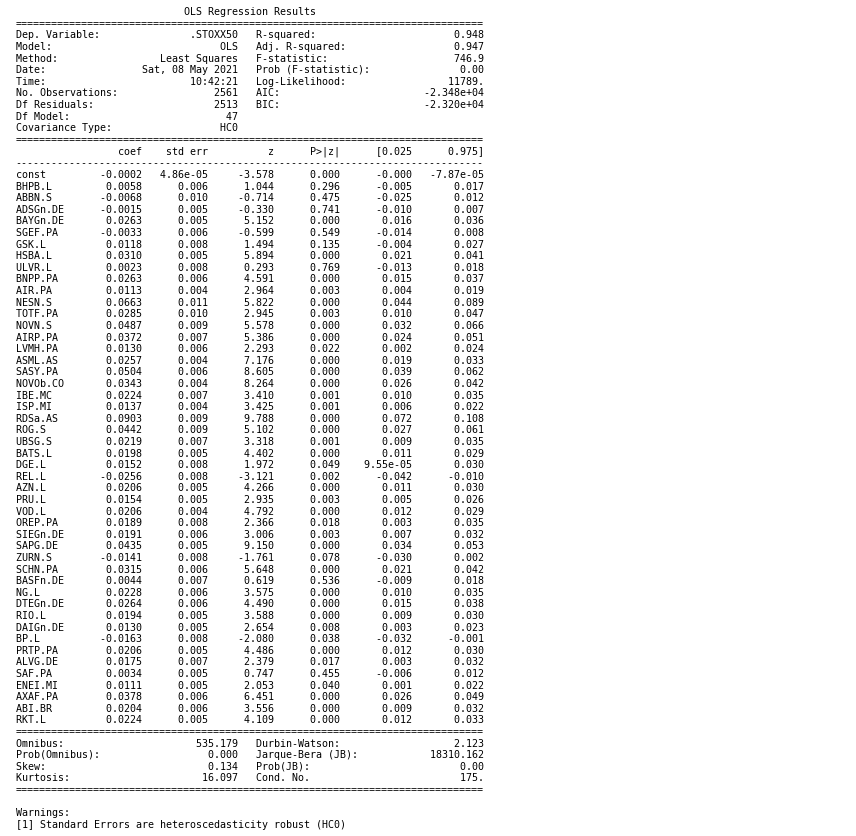

In [71]:
#Save the regression tab
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(results.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('output_multiple_OLS.png')

In [59]:
regression7 = pd.DataFrame(y)



prediction = results.predict()



regression7['Prediction']=prediction
regression7

,.STOXX50,Prediction
Date,,
2011-05-02,-0.000331,0.001535
2011-05-03,-0.003349,-0.001197
2011-05-04,-0.013856,-0.011502
2011-05-05,-0.002356,-0.002630
2011-05-06,0.012094,0.010564
...,...,...
2021-04-19,-0.001507,-0.000588
2021-04-20,-0.018039,-0.017231
2021-04-21,0.010643,0.009631


In [65]:
regression7['Diff']=regression7['.STOXX50']-regression7['Prediction']
regression7['Diff'].mean()

-1.9655006287551352e-17

<function matplotlib.pyplot.show(*args, **kw)>

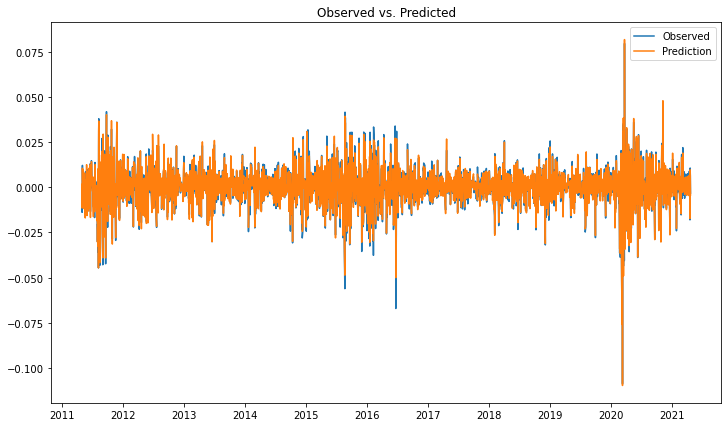

In [62]:
plt.plot(regression7)
labels=['Observed','Prediction']
plt.legend(labels)
plt.title('Observed vs. Predicted')
plt.show

In [74]:
#Let's drop the inisgnificant securities from the original set
y = df_index_analysis1['.STOXX50'].dropna() #we drop the first row of the return dataset as it contains NaN (pct.change)
x = df_index_analysis1[[ 'BAYGn.DE', 'HSBA.L',  'BNPP.PA', 'AIR.PA','NESN.S', 'TOTF.PA', 'NOVN.S', 'AIRP.PA', 'ASML.AS','SASY.PA', 'NOVOb.CO', 'IBE.MC', 'ISP.MI', 'RDSa.AS', 'ROG.S', 'UBSG.S',
       'BATS.L', 'REL.L', 'AZN.L', 'PRU.L', 'VOD.L',
       'SIEGn.DE', 'SAPG.DE', 'SCHN.PA', 'NG.L',
       'DTEGn.DE', 'RIO.L', 'DAIGn.DE', 'PRTP.PA',
       'AXAF.PA', 'ABI.BR', 'RKT.L']].dropna()
x = sm.add_constant(x)
model = sm.OLS(y,x) 
results2 = model.fit(cov_type='HC0')  #controls for Heteroskedasticity
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:               .STOXX50   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     1041.
Date:                Sat, 08 May 2021   Prob (F-statistic):               0.00
Time:                        10:55:39   Log-Likelihood:                 11755.
No. Observations:                2561   AIC:                        -2.344e+04
Df Residuals:                    2528   BIC:                        -2.325e+04
Df Model:                          32                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002   4.92e-05     -3.348      0.0

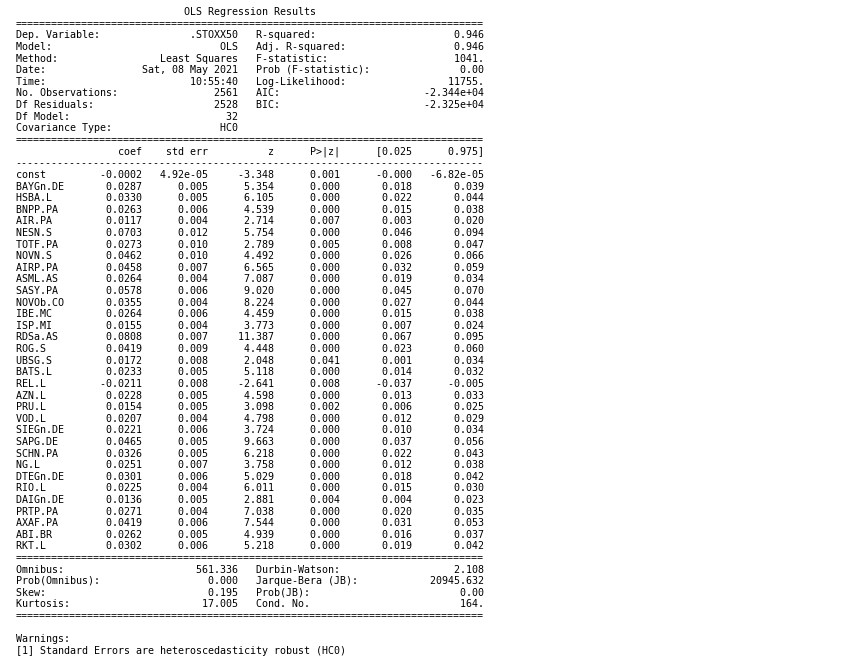

In [75]:
#Save the regression tab
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(results2.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('output_multiple(w.o. insignificant variables)_OLS.png')

In [76]:
regression8 = pd.DataFrame(y)



prediction = results2.predict()



regression8['Prediction']=prediction
regression8

,.STOXX50,Prediction
Date,,
2011-05-02,-0.000331,0.001694
2011-05-03,-0.003349,-0.001383
2011-05-04,-0.013856,-0.011202
2011-05-05,-0.002356,-0.002832
2011-05-06,0.012094,0.010731
...,...,...
2021-04-19,-0.001507,-0.000196
2021-04-20,-0.018039,-0.017493
2021-04-21,0.010643,0.009707


In [77]:
regression8['Diff']=regression8['.STOXX50']-regression8['Prediction']
regression8['Diff'].mean()

-4.517703229061767e-16

<function matplotlib.pyplot.show(*args, **kw)>

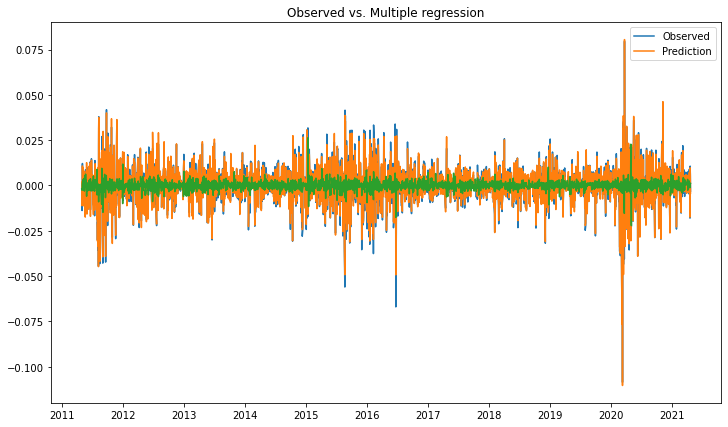

In [78]:
plt.plot(regression8)
labels=['Observed','Prediction']
plt.legend(labels)
plt.title('Observed vs. Multiple regression')
plt.show

# Heteroskedasticity

<function matplotlib.pyplot.show(*args, **kw)>

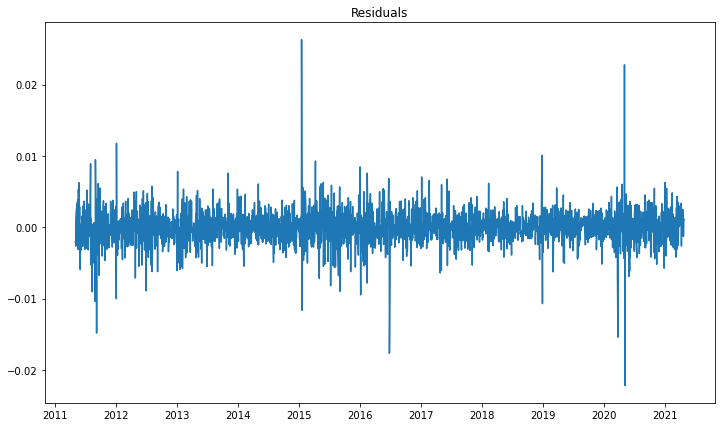

In [95]:
Residuals=df_index_analysis1['.STOXX50'].dropna()-prediction
plt.plot(Residuals)
plt.title('Residuals')
plt.show

#It is not perfectly clear whether our residuals show heteroskedasticity. There is no real pattern. If there is heteroskedasticity, we should observe a Fan-shaped figure, which would mean that errors will be growing systematically over time underpinned by omitted variable in the time series.
#Since using the HCO method in our regression did not change the significance of our model, this additional finding confirms our hypothesis that our dataset presents homoskedasticity.

In [90]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

In [94]:
#Breusch-Pagan test
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(results2.resid, results2.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 162.52732789380633),
 ('p-value', 2.122154484567639e-19),
 ('f-value', 5.353264622496483),
 ('f p-value', 3.78998887930895e-20)]

# Autocorrelation

In [96]:
dw_pvalue1=sm.stats.stattools.durbin_watson(Residuals)
print("\n","Durbin Watson Test Statistics", dw_pvalue1)


 Durbin Watson Test Statistics 2.1082569201685506


# Correlation

In [101]:
corr=df_index_analysis[['BNPP.PA','AIR.PA','SAPG.DE']].corr()
corr

,BNPP.PA,AIR.PA,SAPG.DE
BNPP.PA,1.000000,0.518419,0.443763
AIR.PA,0.518419,1.000000,0.450535
SAPG.DE,0.443763,0.450535,1.000000


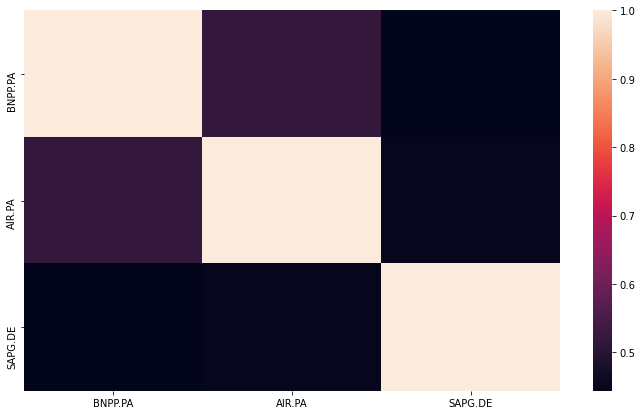

In [102]:
#Heatmap
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# Multicolinearity test

In [103]:
def vif_cal(input_data, dependent_col):
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(formula="y~x", data=x_vars,endog=y, exog=x).fit().rsquared  
        vif=round(1/(1-rsq),2)
        print (xvar_names[i], " VIF = " , vif)

In [104]:
#Calculating VIF values using that function
vif_cal(input_data=df_index_analysis1[['.STOXX50','BAYGn.DE', 'HSBA.L',  'BNPP.PA', 'AIR.PA','NESN.S', 'TOTF.PA', 'NOVN.S', 'AIRP.PA', 'ASML.AS','SASY.PA', 'NOVOb.CO', 'IBE.MC', 'ISP.MI', 'RDSa.AS', 'ROG.S', 'UBSG.S',
       'BATS.L', 'REL.L', 'AZN.L', 'PRU.L', 'VOD.L',
       'SIEGn.DE', 'SAPG.DE', 'SCHN.PA', 'NG.L',
       'DTEGn.DE', 'RIO.L', 'DAIGn.DE', 'PRTP.PA',
       'AXAF.PA', 'ABI.BR', 'RKT.L']].dropna(), dependent_col='.STOXX50')

BAYGn.DE  VIF =  2.24
HSBA.L  VIF =  2.15
BNPP.PA  VIF =  4.26
AIR.PA  VIF =  1.96
NESN.S  VIF =  2.13
TOTF.PA  VIF =  4.41
NOVN.S  VIF =  2.6
AIRP.PA  VIF =  2.76
ASML.AS  VIF =  1.71
SASY.PA  VIF =  2.21
NOVOb.CO  VIF =  1.37
IBE.MC  VIF =  2.23
ISP.MI  VIF =  3.05
RDSa.AS  VIF =  3.43
ROG.S  VIF =  2.4
UBSG.S  VIF =  2.56
BATS.L  VIF =  1.59
REL.L  VIF =  1.91
AZN.L  VIF =  1.58
PRU.L  VIF =  2.96
VOD.L  VIF =  1.69
SIEGn.DE  VIF =  3.11
SAPG.DE  VIF =  2.0
SCHN.PA  VIF =  3.31
NG.L  VIF =  1.7
DTEGn.DE  VIF =  2.08
RIO.L  VIF =  1.76
DAIGn.DE  VIF =  2.88
PRTP.PA  VIF =  1.92
AXAF.PA  VIF =  4.15
ABI.BR  VIF =  2.02
RKT.L  VIF =  1.6


# Normality tests 

Mean: 0.00015164378220846437
Standard deviation: 0.010593661120163755
Trading days: 2561
Mean: 0.0002298414723858924
Standard deviation: 0.021407494427934198
Trading days: 2561
Mean: 0.00019704179638266062
Standard deviation: 0.01470710914647883
Trading days: 2561
Mean: 0.0008064798192859257
Standard deviation: 0.017633191890739724
Trading days: 2561
Mean: 0.00013651257324645677
Standard deviation: 0.018032021609262348
Trading days: 2561
Mean: 0.00041682587657595023
Standard deviation: 0.017555564965505983
Trading days: 2561
Mean: 8.595515177186104e-05
Standard deviation: 0.01204305755911777
Trading days: 2561
Mean: -6.889972573202334e-05
Standard deviation: 0.014834601169795682
Trading days: 2561
Mean: 0.00035869074157899173
Standard deviation: 0.012237736529325922
Trading days: 2561
Mean: 0.0002468882321974965
Standard deviation: 0.0231879618273886
Trading days: 2561
Mean: 0.0008594297010317445
Standard deviation: 0.022524817115938754
Trading days: 2561
Mean: 0.0003259010227675208
St

C:\Users\User1\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\Users\User1\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\Users\User1\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too muc

Mean: -4.9060814333436866e-05
Standard deviation: 0.017229686329887188
Trading days: 2561
Mean: 0.00038372414252628884
Standard deviation: 0.012218990258563517
Trading days: 2561
Mean: 9.18468267967983e-05
Standard deviation: 0.01863252728669086
Trading days: 2561
Mean: 0.00011068776114859801
Standard deviation: 0.014186172482703709
Trading days: 2561


C:\Users\User1\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\Users\User1\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\Users\User1\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too muc

Mean: 0.00046618461885312973
Standard deviation: 0.012661812522481535
Trading days: 2561
Mean: 0.000578987507626535
Standard deviation: 0.012550923078227263
Trading days: 2561
Mean: 0.00045959921340994774
Standard deviation: 0.014578546351051566
Trading days: 2561
Mean: 0.0005192237559218239
Standard deviation: 0.019771458697317813
Trading days: 2561


C:\Users\User1\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\Users\User1\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\Users\User1\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too muc

Mean: 1.1485278116943444e-05
Standard deviation: 0.014961825512769093
Trading days: 2561
Mean: 0.000632268017801736
Standard deviation: 0.013234272593534786
Trading days: 2561
Mean: 0.0002619805805858293
Standard deviation: 0.01518697609648344
Trading days: 2561
Mean: 0.0005074561926360939
Standard deviation: 0.01492871879226737
Trading days: 2561
Mean: 0.0002747781374443149
Standard deviation: 0.014266847571479066
Trading days: 2561
Mean: 0.000495577912693801
Standard deviation: 0.018439585289885874
Trading days: 2561


C:\Users\User1\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\Users\User1\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\Users\User1\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too muc

Mean: 0.00014260863815123437
Standard deviation: 0.016536675336401224
Trading days: 2561
Mean: 0.0002210096415894665
Standard deviation: 0.012064286365014916
Trading days: 2561
Mean: 0.00024359486203205405
Standard deviation: 0.014325123957084846
Trading days: 2561


C:\Users\User1\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\Users\User1\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\Users\User1\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too muc

Mean: 0.0003751791875521787
Standard deviation: 0.0205907952825532
Trading days: 2561
Mean: 0.00033514050676485804
Standard deviation: 0.02005785780933458
Trading days: 2561


C:\Users\User1\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\Users\User1\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


Mean: -1.5357561978603266e-05
Standard deviation: 0.01791109115031431
Trading days: 2561
Mean: 0.0008573571819530541
Standard deviation: 0.01820358986705042
Trading days: 2561
Mean: 0.0004138342906683311
Standard deviation: 0.016495809214864772
Trading days: 2561
Mean: 0.0008131720916820965

C:\Users\User1\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\Users\User1\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\Users\User1\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too muc


Standard deviation: 0.02069395553487601
Trading days: 2561
Mean: 0.000386038625117204
Standard deviation: 0.017421771298243526
Trading days: 2561
Mean: 0.00037199271029833005
Standard deviation: 0.020266024200381257
Trading days: 2561
Mean: 0.0002644191310903638

C:\Users\User1\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\Users\User1\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\Users\User1\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too muc


Standard deviation: 0.016968618249604987
Trading days: 2561
Mean: 0.0003499729169224032
Standard deviation: 0.012734517584519689
Trading days: 2561


C:\Users\User1\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\Users\User1\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


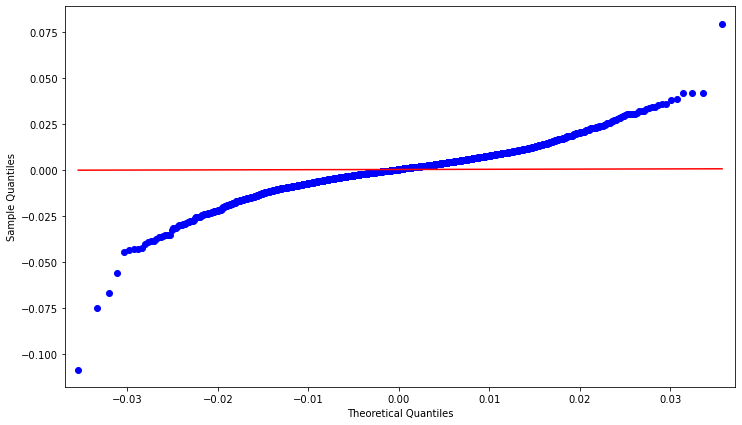

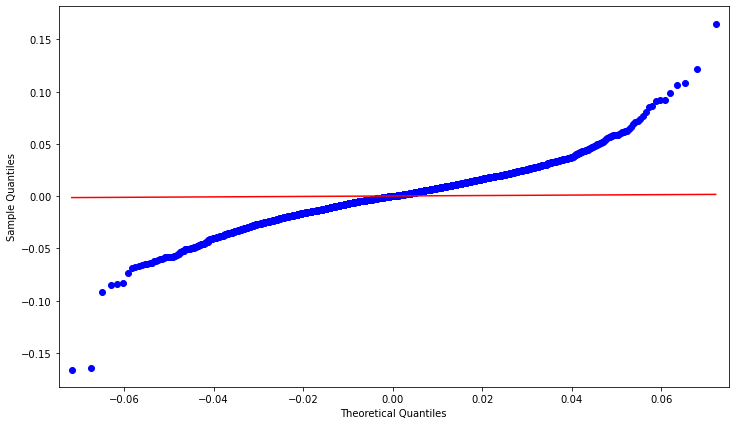

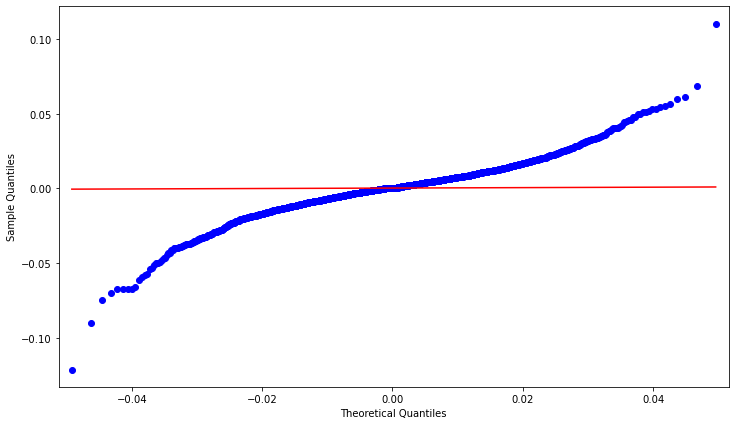

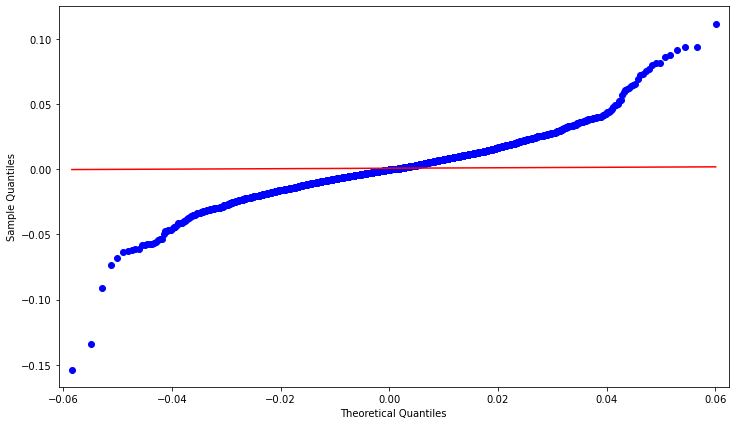

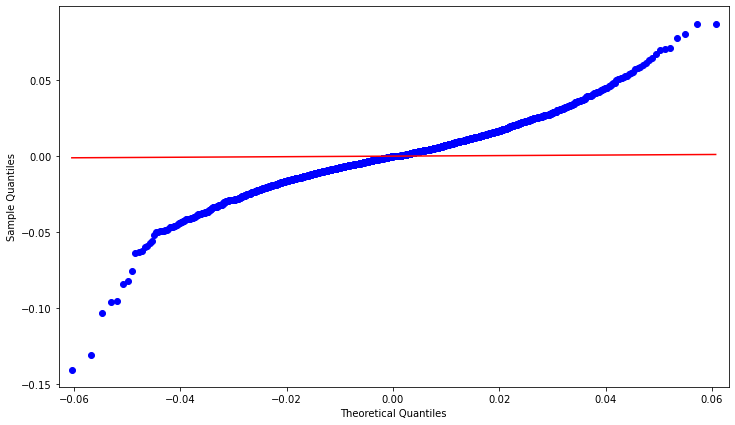

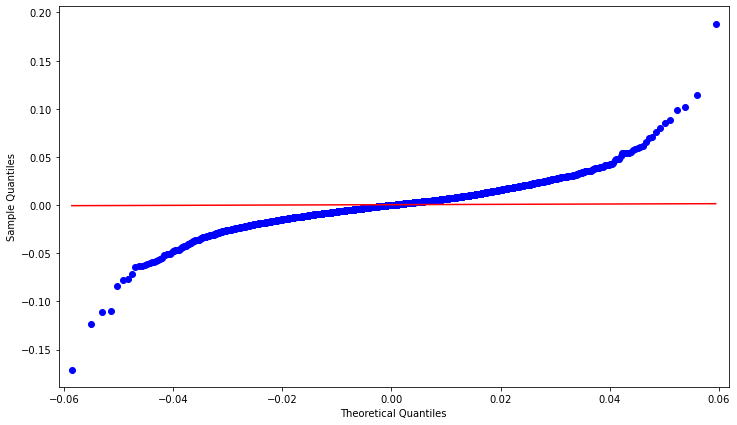

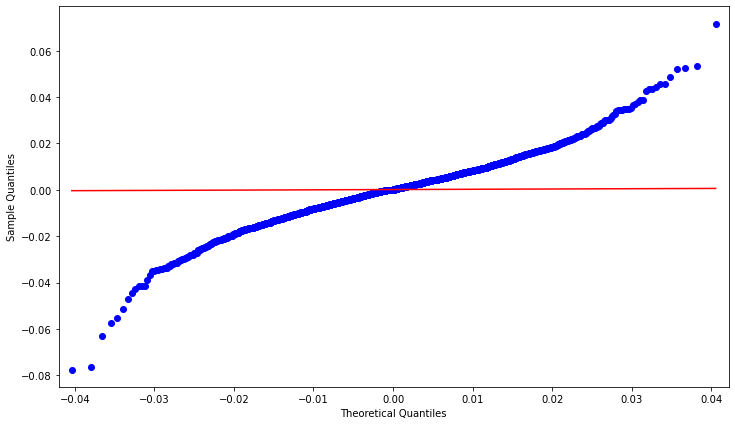

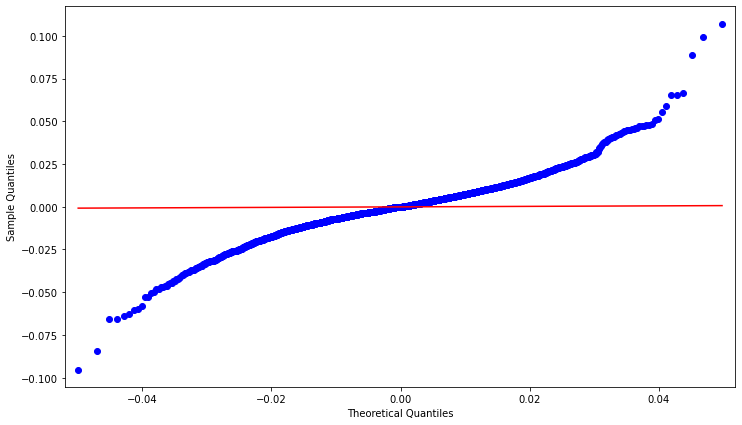

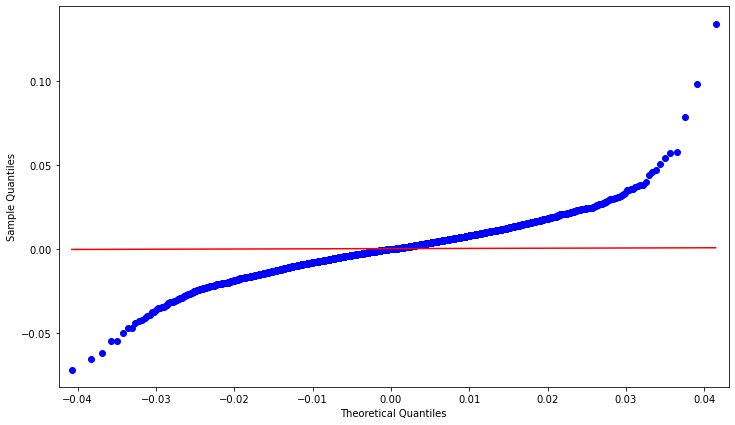

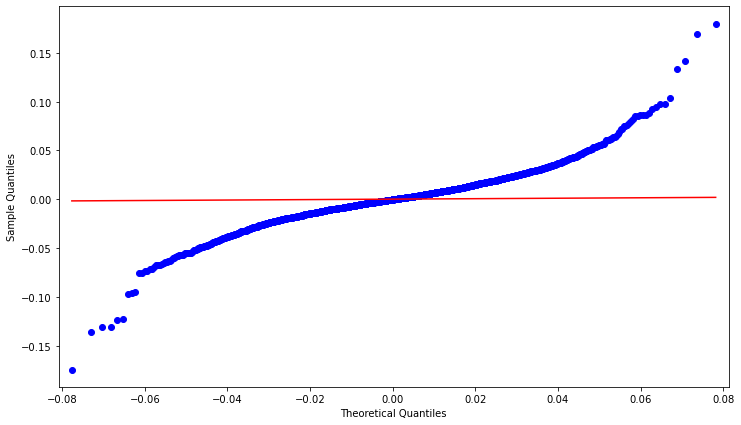

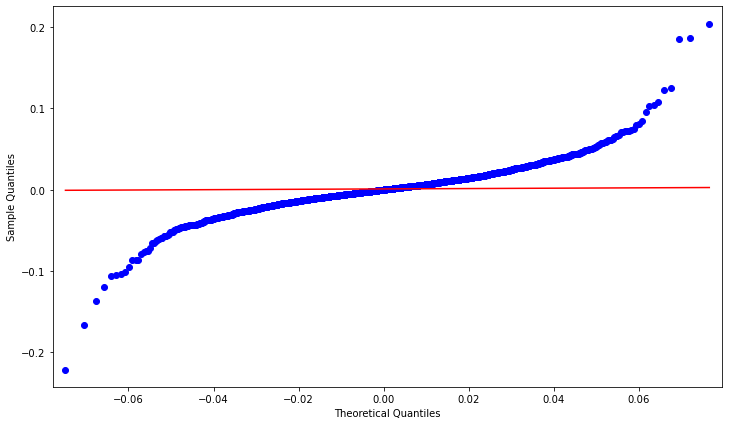

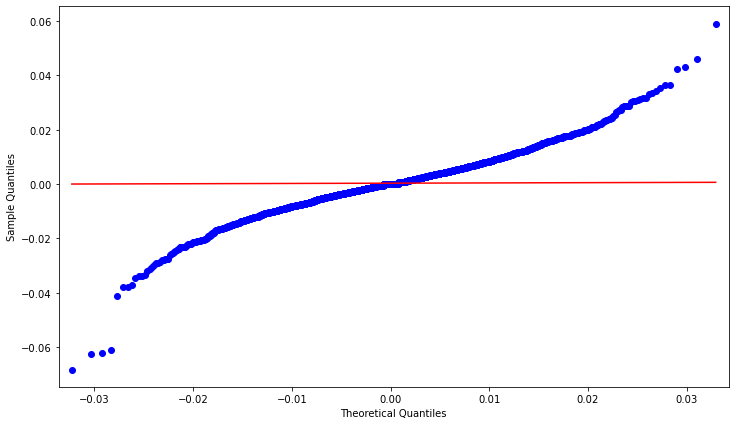

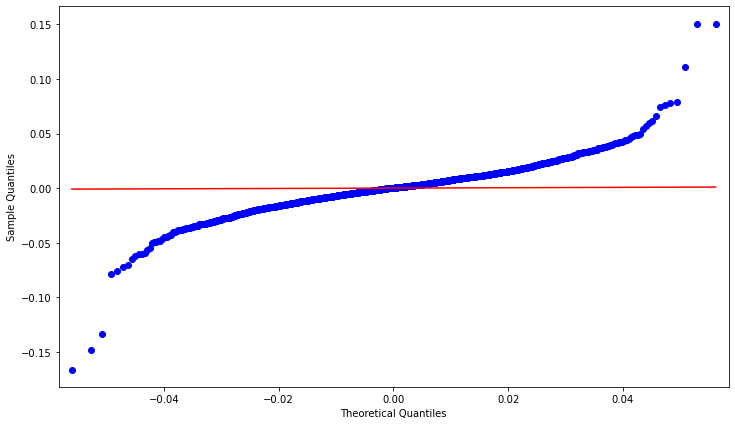

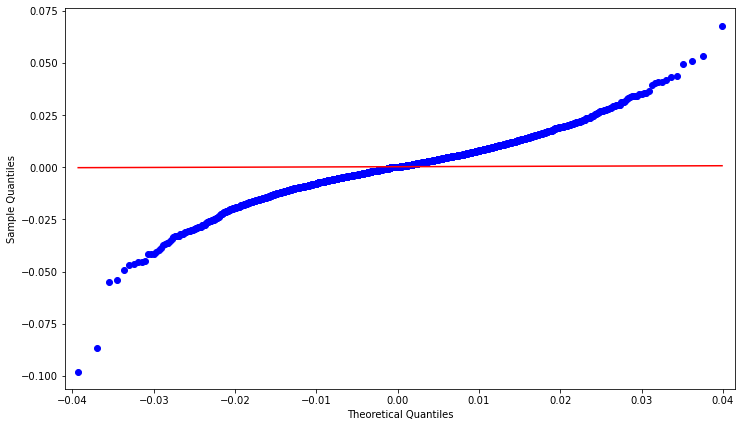

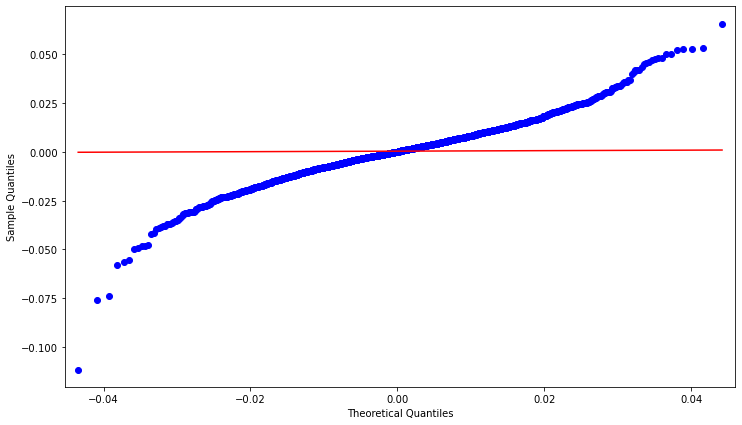

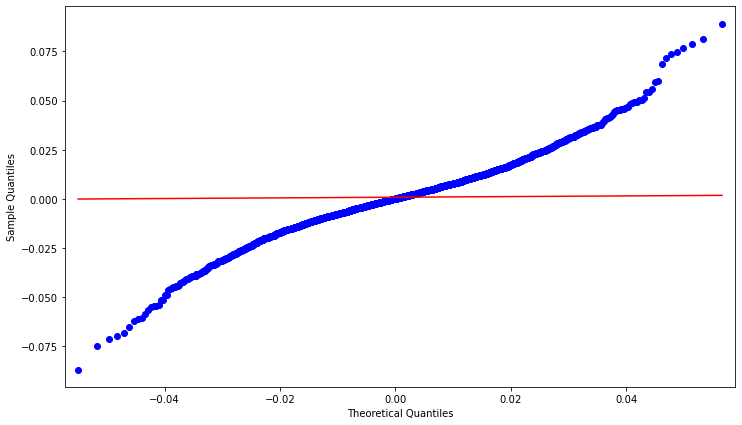

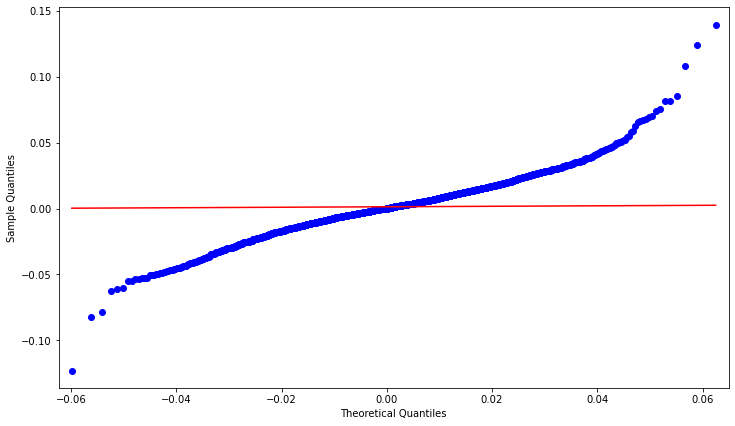

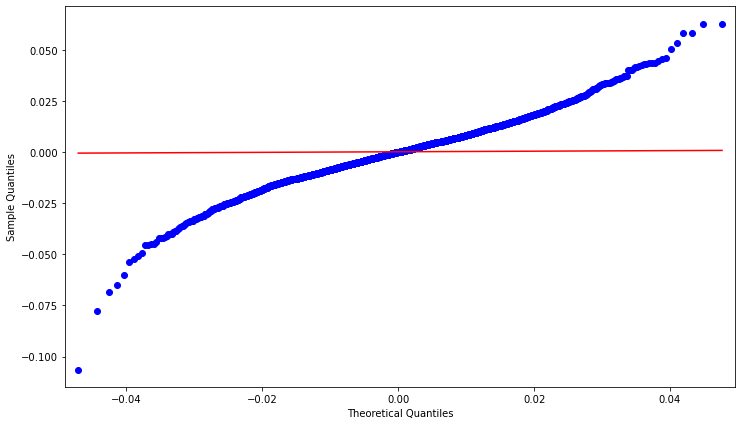

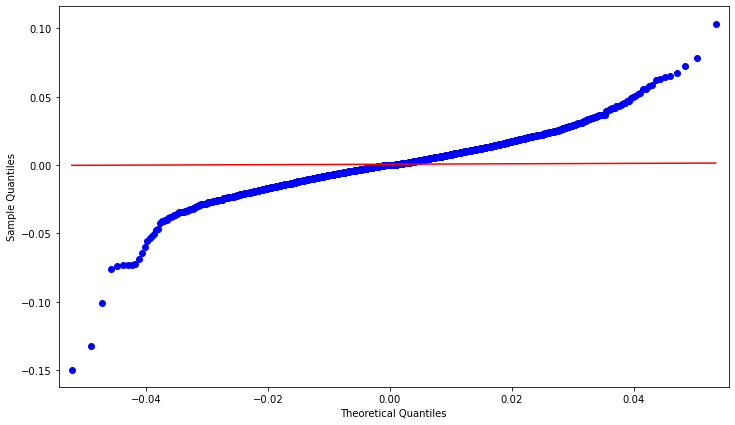

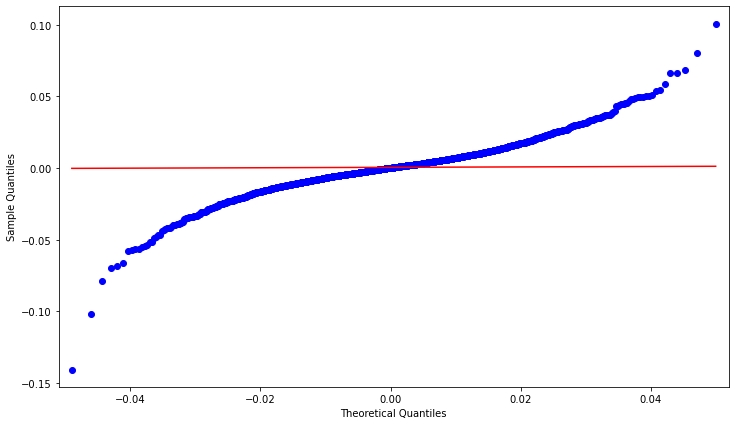

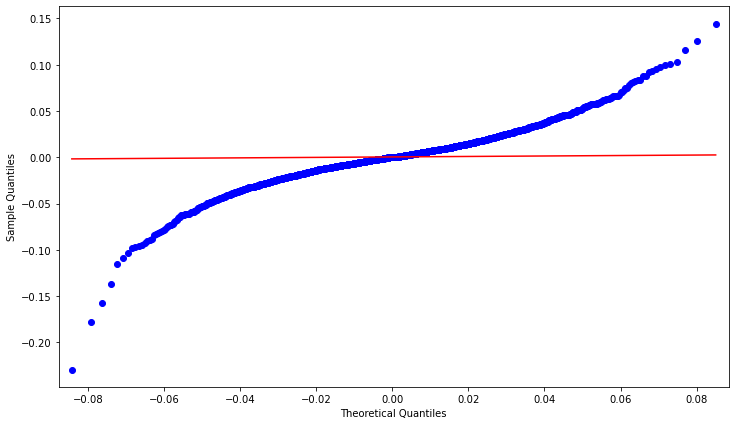

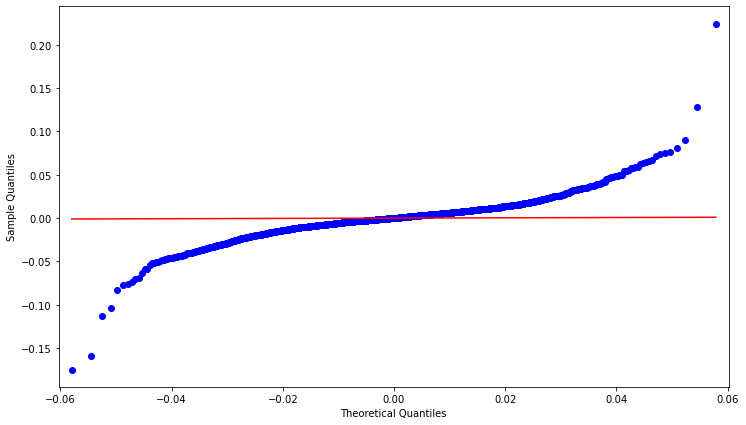

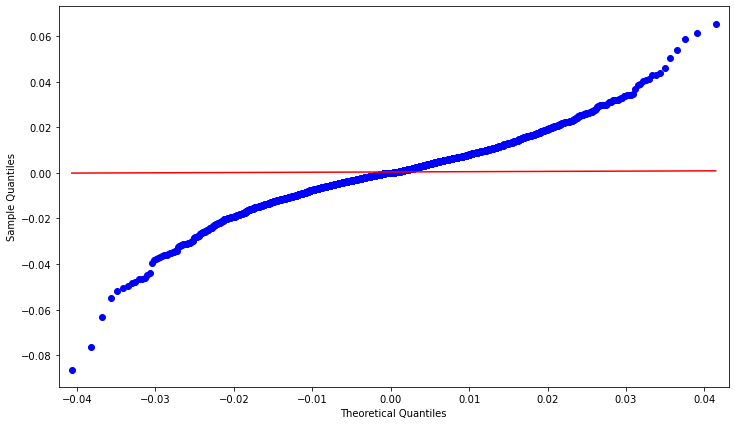

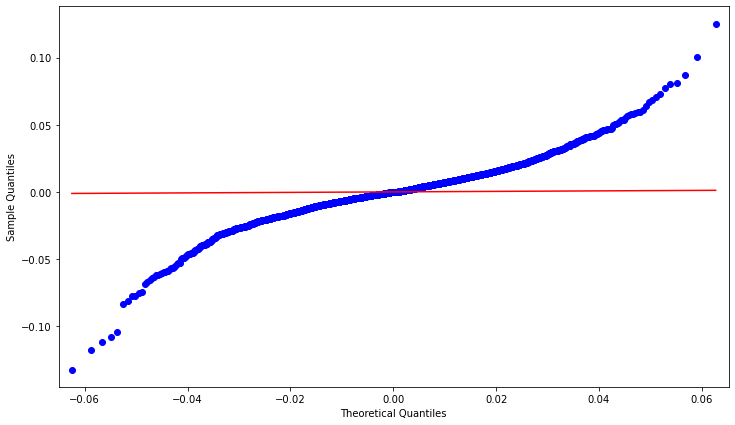

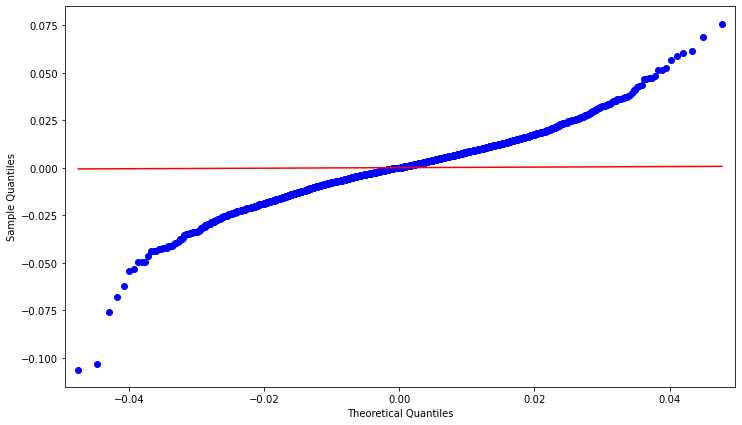

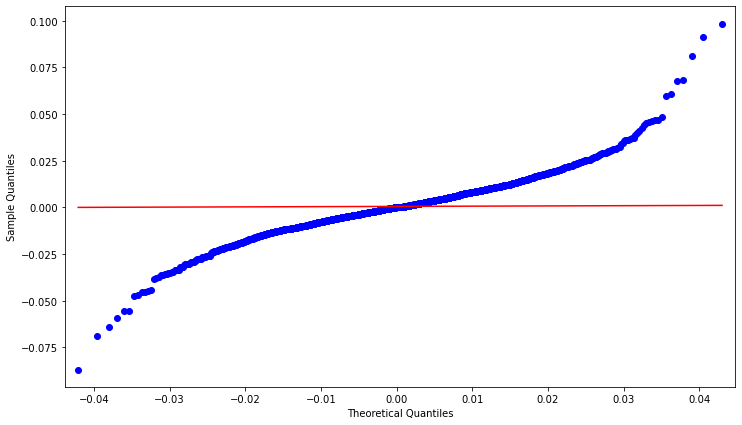

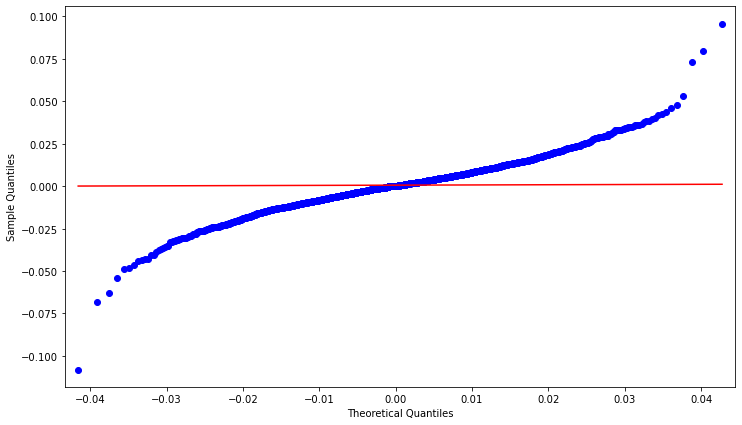

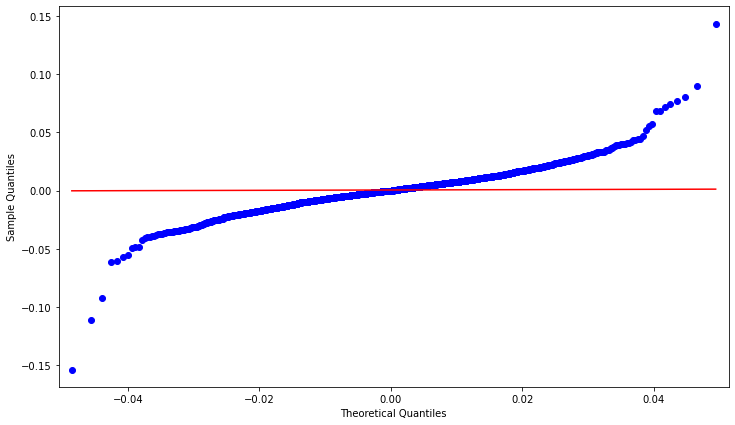

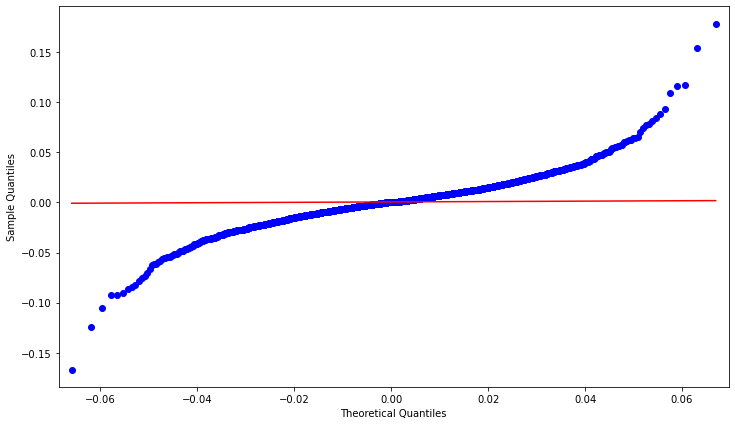

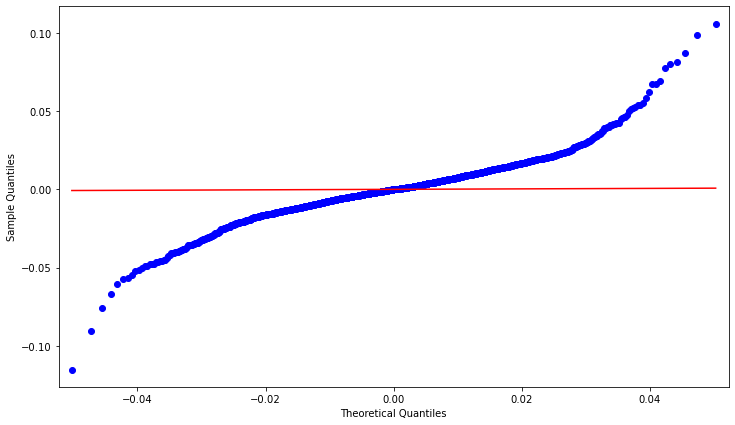

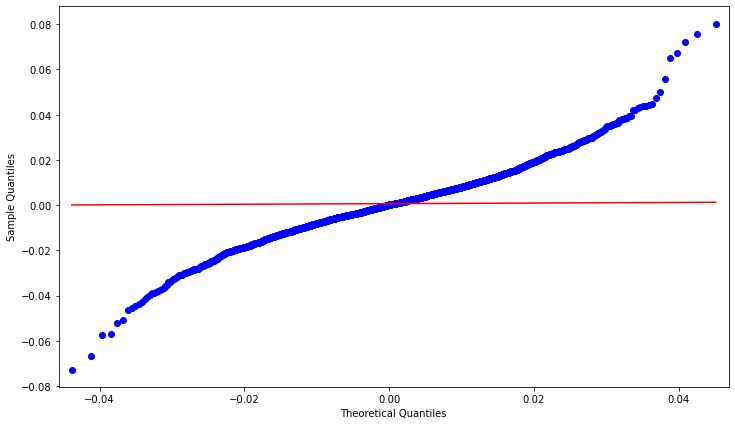

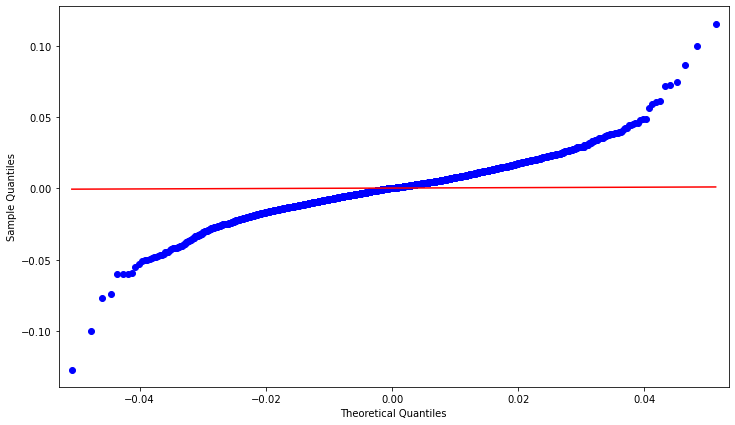

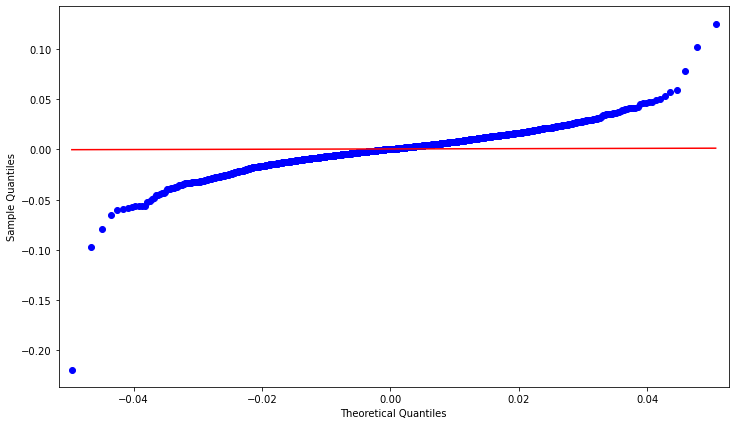

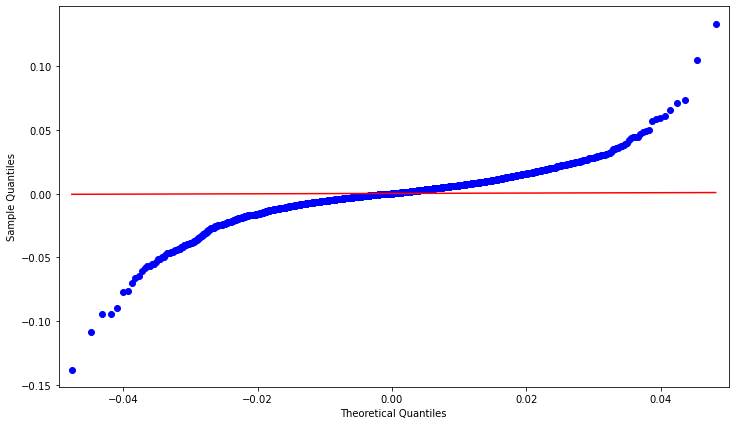

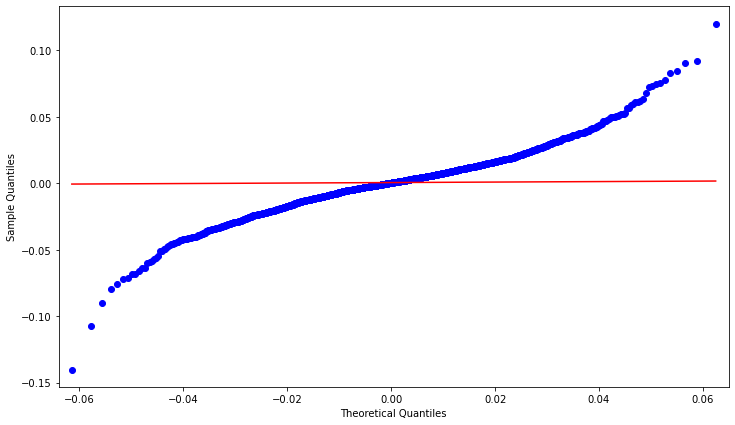

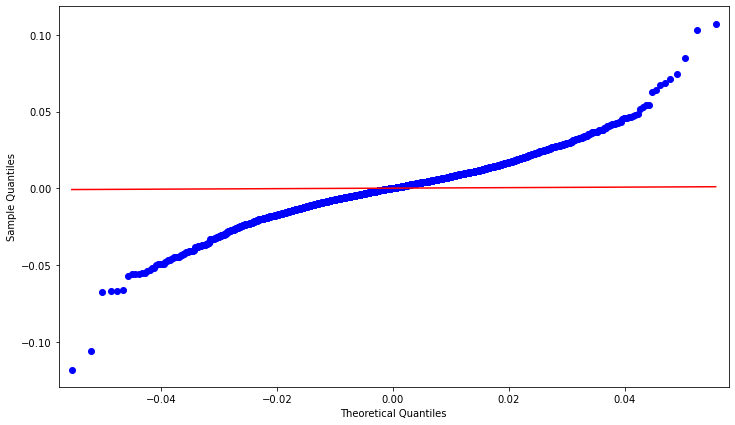

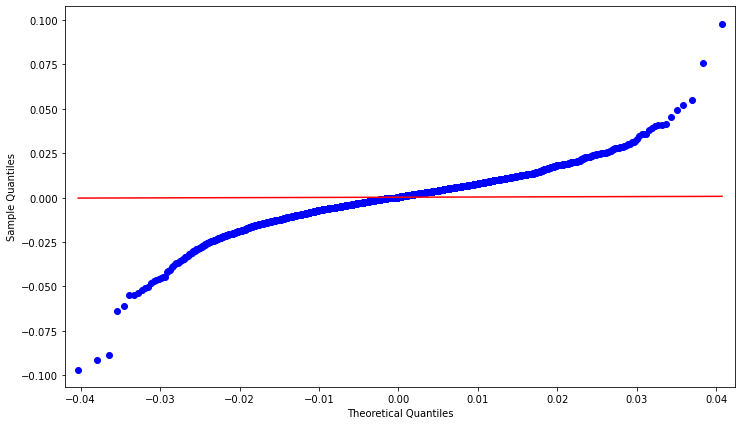

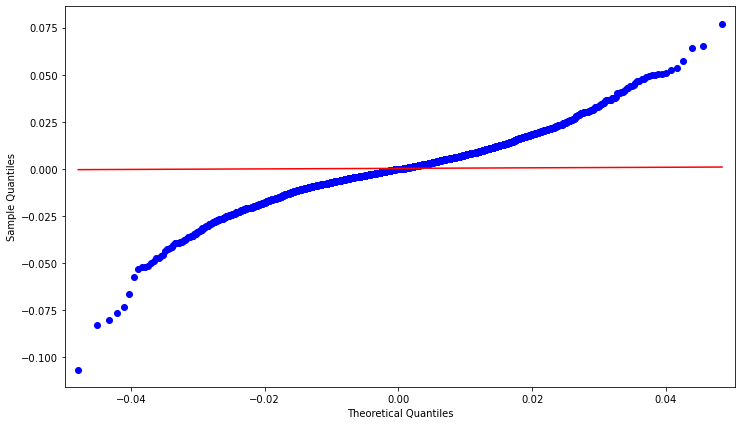

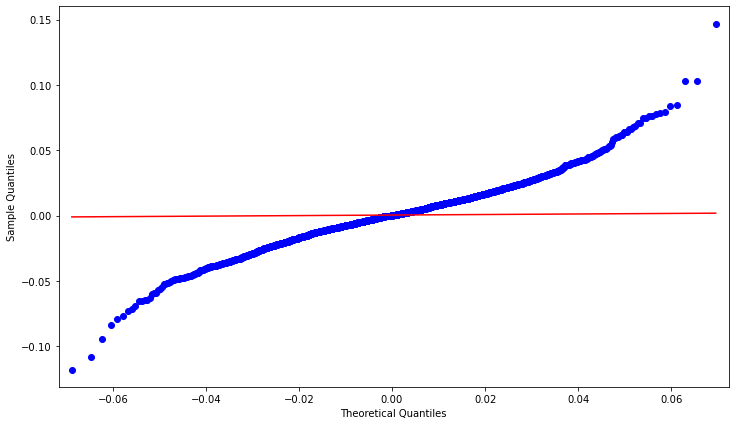

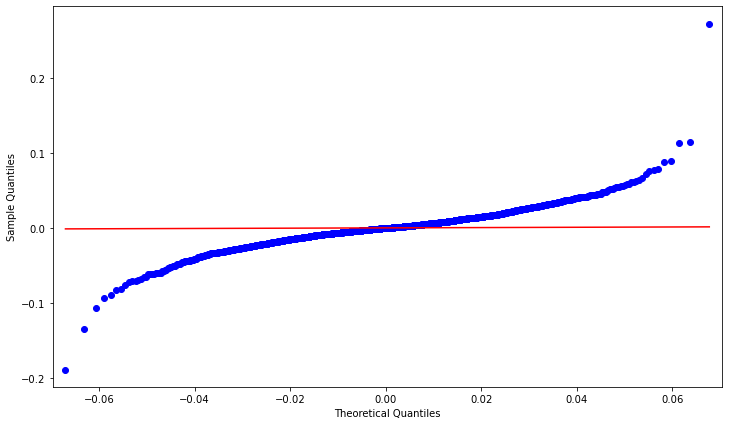

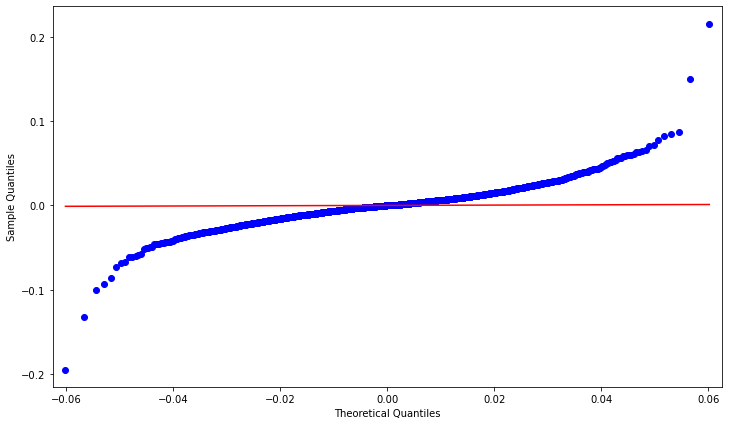

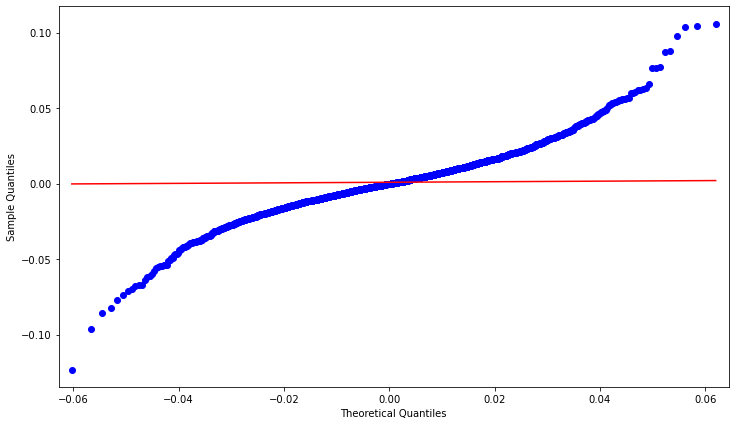

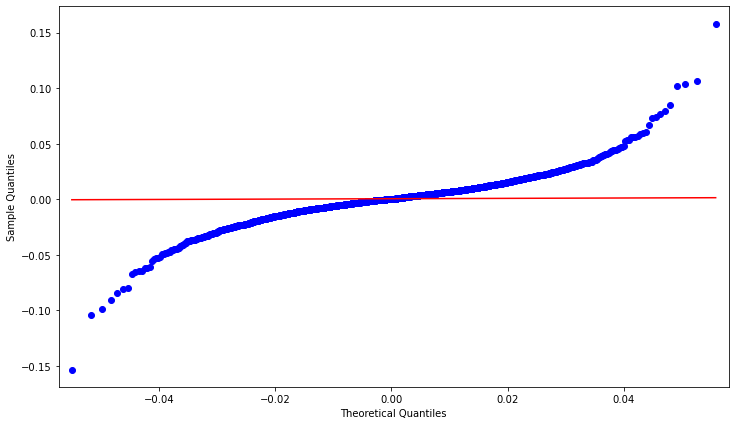

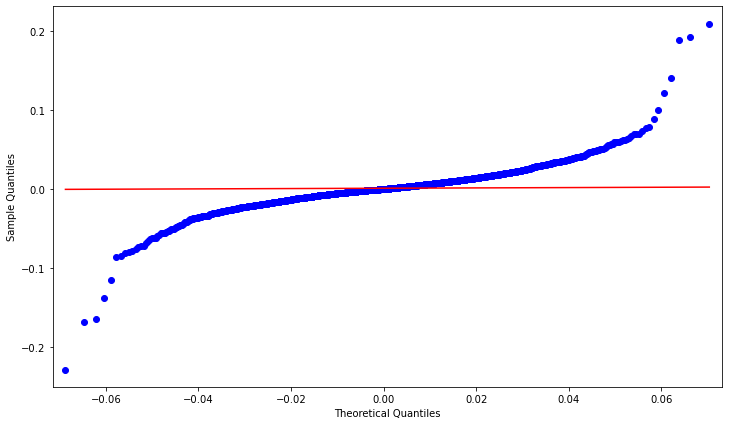

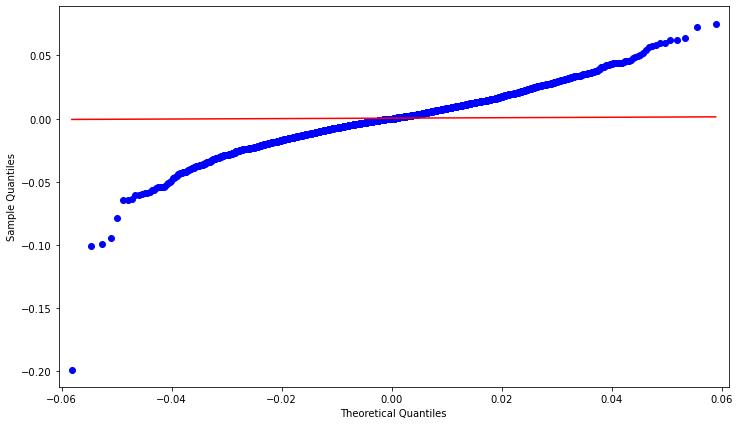

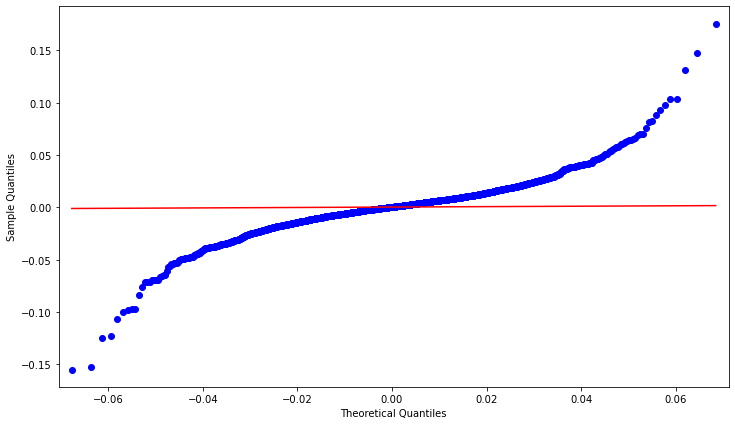

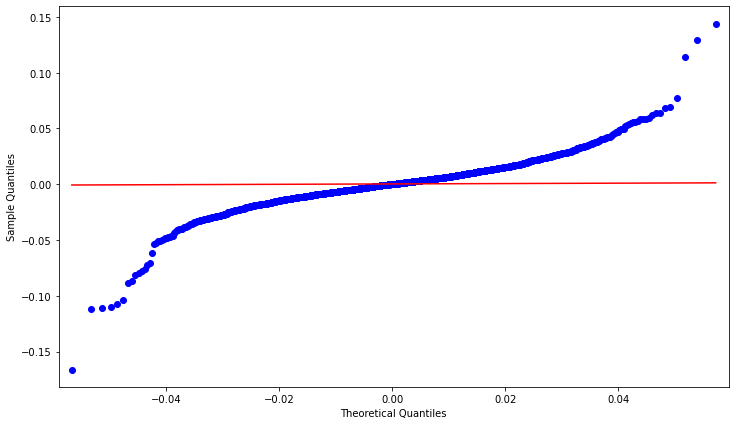

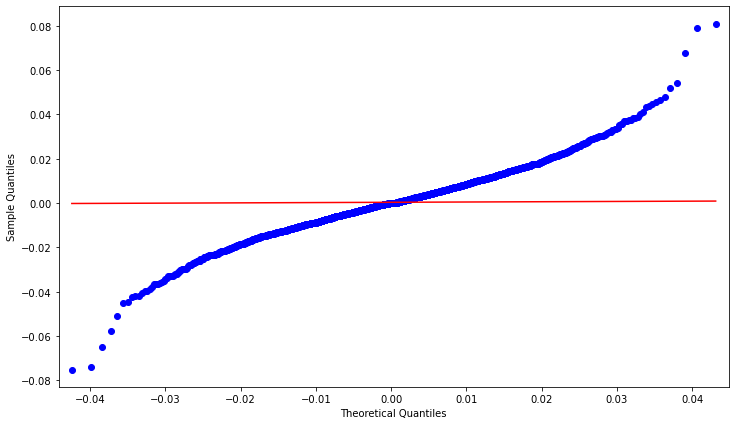

In [134]:
import statistics
for column in df_index_analysis1:
    nor=df_index_analysis1[column].dropna()
    mean1=statistics.mean(nor)
    st_dev1=statistics.stdev(nor)
    obs_count1=len(nor)
    print('Mean: '+ str(mean1))
    print('Standard deviation: '+str(st_dev1))
    print('Trading days: '+ str(obs_count1))
    sm.qqplot(nor, loc = mean1, scale = st_dev1, line='s')

    
    
    

In [ ]:
#save the charts as png
for col in df_index_raw.iteritems():
    print('plotting'+col[0])
    fig, ax = plt.subplots()
    indicator=df_index_analysis1[col[0]]
    ax.plot(indicator, alpha=0.9, color='blue')
    plt.title(col[0])
    plt.savefig('Charts_QQ_'+col[0]+'.png') 
    plt.close()

In [ ]:
Given the shape of the 

In [106]:
for column in df_index_analysis1:
    nor=df_index_analysis1[column][1:257]
    jb=stats.jarque_bera(nor)
    print(jb)

Jarque_beraResult(statistic=27.622140726744195, pvalue=1.0044500668993095e-06)
Jarque_beraResult(statistic=21.54189100529138, pvalue=2.100089498857649e-05)
Jarque_beraResult(statistic=11.752774043897732, pvalue=0.0028049010359002535)
Jarque_beraResult(statistic=16.47655243207925, pvalue=0.0002643395211736621)
Jarque_beraResult(statistic=17.263954017923428, pvalue=0.00017831177249161279)
Jarque_beraResult(statistic=3.2341614688530336, pvalue=0.19847726202143845)
Jarque_beraResult(statistic=11.300871733699836, pvalue=0.0035159839400361603)
Jarque_beraResult(statistic=26.63213531756525, pvalue=1.6478030225863805e-06)
Jarque_beraResult(statistic=5.973636372353578, pvalue=0.050447696808564424)
Jarque_beraResult(statistic=56.32423576697807, pvalue=5.879741138414829e-13)
Jarque_beraResult(statistic=93.0861649283755, pvalue=0.0)
Jarque_beraResult(statistic=163.76551534318708, pvalue=0.0)
Jarque_beraResult(statistic=19.26494970167819, pvalue=6.556458629547457e-05)
Jarque_beraResult(statistic=20

# Stationary test (Price dataset)

In [136]:
var_list=df_index[['BNPP.PA','AIR.PA','SAPG.DE']].dropna()


for i in var_list:
    for lags in range(1,3):
        print('Number of lags used:',lags)

        adf_library = adfuller(df_index[i].dropna(), maxlag=lags, regression='nc',autolag=None) #here we llok at the prices 
        adf_library_d = adfuller(np.diff(df_index[i].dropna()), maxlag=lags, regression='nc',autolag=None) #here we look at th diff from 1 day to the next

        print(i,'in Level','\n',
              'ADF Stat (Library) for',i,':',"%.2f" % adf_library[0],'\n',
              'ADF P-Val (Library)',i,':',"%.2f" %  adf_library[1],'\n')

        print(i,'in 1st Difference','\n',
              'ADF Stat (Library) for',i,':',"%.2f" % adf_library_d[0],'\n',
              'ADF P-Val (Library)',i,':',"%.2f" %  adf_library_d[1],'\n')
    print('____________________________________________','\n')

Number of lags used: 1
BNPP.PA in Level 
 ADF Stat (Library) for BNPP.PA : -0.57 
 ADF P-Val (Library) BNPP.PA : 0.47 

BNPP.PA in 1st Difference 
 ADF Stat (Library) for BNPP.PA : -35.21 
 ADF P-Val (Library) BNPP.PA : 0.00 

Number of lags used: 2
BNPP.PA in Level 
 ADF Stat (Library) for BNPP.PA : -0.57 
 ADF P-Val (Library) BNPP.PA : 0.47 

BNPP.PA in 1st Difference 
 ADF Stat (Library) for BNPP.PA : -30.22 
 ADF P-Val (Library) BNPP.PA : 0.00 

____________________________________________ 

Number of lags used: 1
AIR.PA in Level 
 ADF Stat (Library) for AIR.PA : 0.23 
 ADF P-Val (Library) AIR.PA : 0.76 

AIR.PA in 1st Difference 
 ADF Stat (Library) for AIR.PA : -36.58 
 ADF P-Val (Library) AIR.PA : 0.00 

Number of lags used: 2
AIR.PA in Level 
 ADF Stat (Library) for AIR.PA : 0.31 
 ADF P-Val (Library) AIR.PA : 0.78 

AIR.PA in 1st Difference 
 ADF Stat (Library) for AIR.PA : -28.90 
 ADF P-Val (Library) AIR.PA : 0.00 

____________________________________________ 

Number of la

# Stationary Test (Return dataset)

In [137]:
var_list=df_index_analysis1[['BNPP.PA','AIR.PA','SAPG.DE']].dropna()


for i in var_list:
    for lags in range(1,3):
        print('Number of lags used:',lags)

        adf_library = adfuller(df_index_analysis1[i].dropna(), maxlag=lags, regression='nc',autolag=None) #here we llok at the prices 
        adf_library_d = adfuller(np.diff(df_index_analysis1[i].dropna()), maxlag=lags, regression='nc',autolag=None) #here we look at th diff from 1 day to the next

        print(i,'in Level','\n',
              'ADF Stat (Library) for',i,':',"%.2f" % adf_library[0],'\n',
              'ADF P-Val (Library)',i,':',"%.2f" %  adf_library[1],'\n')

        print(i,'in 1st Difference','\n',
              'ADF Stat (Library) for',i,':',"%.2f" % adf_library_d[0],'\n',
              'ADF P-Val (Library)',i,':',"%.2f" %  adf_library_d[1],'\n')
    print('____________________________________________','\n')

Number of lags used: 1
BNPP.PA in Level 
 ADF Stat (Library) for BNPP.PA : -35.13 
 ADF P-Val (Library) BNPP.PA : 0.00 

BNPP.PA in 1st Difference 
 ADF Stat (Library) for BNPP.PA : -57.26 
 ADF P-Val (Library) BNPP.PA : 0.00 

Number of lags used: 2
BNPP.PA in Level 
 ADF Stat (Library) for BNPP.PA : -31.37 
 ADF P-Val (Library) BNPP.PA : 0.00 

BNPP.PA in 1st Difference 
 ADF Stat (Library) for BNPP.PA : -50.01 
 ADF P-Val (Library) BNPP.PA : 0.00 

____________________________________________ 

Number of lags used: 1
AIR.PA in Level 
 ADF Stat (Library) for AIR.PA : -37.50 
 ADF P-Val (Library) AIR.PA : 0.00 

AIR.PA in 1st Difference 
 ADF Stat (Library) for AIR.PA : -62.02 
 ADF P-Val (Library) AIR.PA : 0.00 

Number of lags used: 2
AIR.PA in Level 
 ADF Stat (Library) for AIR.PA : -30.05 
 ADF P-Val (Library) AIR.PA : 0.00 

AIR.PA in 1st Difference 
 ADF Stat (Library) for AIR.PA : -51.98 
 ADF P-Val (Library) AIR.PA : 0.00 

____________________________________________ 

Number

# Stationary test for all stocks in the Index

In [140]:
for lags in range(1,3):
    print('Number of lags used:',lags)
    print('ADF P-Val for Prices (Level)')
    for i in df_index:
        adf_library = adfuller(df_index[i], maxlag=lags, regression='nc',autolag=None)
        adf_library_d = adfuller(np.diff(df_index[i]), maxlag=lags, regression='nc',autolag=None)

        print(i,':',"%.2f" %  adf_library[1],)
    print('____________________________________________','\n')
    
#All p-values are high which means the stocks are not stationary (H0 cannot be rejected)

Number of lags used: 1
ADF P-Val for Prices (Level)
.STOXX50 : 0.76
BHPB.L : 0.51
ABBN.S : 0.72
ADSGn.DE : 0.90
LINI.DE : 0.97
BAYGn.DE : 0.52
SGEF.PA : 0.80
GSK.L : 0.60
HSBA.L : 0.33
ADYEN.AS : 1.00
ULVR.L : 0.85
BNPP.PA : 0.47
AIR.PA : 0.76
NESN.S : 0.94
TOTF.PA : 0.47
NOVN.S : 0.80
AIRP.PA : 0.94
LVMH.PA : 1.00
ASML.AS : 1.00
SASY.PA : 0.74
NOVOb.CO : 0.90
IBE.MC : 0.99
ISP.MI : 0.50
RDSa.AS : 0.36
ROG.S : 0.86
UBSG.S : 0.42
BATS.L : 0.57
DGE.L : 0.93
REL.L : 0.94
AZN.L : 0.88
PRU.L : 0.75
VOD.L : 0.46
OREP.PA : 1.00
SIEGn.DE : 0.79
SAPG.DE : 0.88
ZURN.S : 0.78
SCHN.PA : 0.96
BASFn.DE : 0.55
NG.L : 0.74
PRX.AS : 0.78
DTEGn.DE : 0.74
RIO.L : 0.81
DAIGn.DE : 0.67
BP.L : 0.38
PRTP.PA : 0.98
ALVG.DE : 0.84
SAF.PA : 0.82
ENEI.MI : 0.91
AXAF.PA : 0.67
ABI.BR : 0.61
RKT.L : 0.81
____________________________________________ 

Number of lags used: 2
ADF P-Val for Prices (Level)
.STOXX50 : 0.76
BHPB.L : 0.50
ABBN.S : 0.73
ADSGn.DE : 0.90
LINI.DE : 0.97
BAYGn.DE : 0.52
SGEF.PA : 0.80
GSK.L : 

In [35]:
for lags in range(1,3):
    print('Number of lags used:',lags)
    print('ADF P-Val for Absolute Returns (1st Difference)')
    for i in df_index:
        adf_library = adfuller(df_index[i], maxlag=lags, regression='nc',autolag=None)
        adf_library_d = adfuller(np.diff(df_index[i]), maxlag=lags, regression='nc',autolag=None)

        print(i,':',"%.2f" %  adf_library_d[1])
    print('____________________________________________','\n')

Number of lags used: 1
ADF P-Val for Absolute Returns (1st Difference)
Date : 0.00
.STOXX50 : 0.00
BHPB.L : 0.00
ABBN.S : 0.00
ADSGn.DE : 0.00
BAYGn.DE : 0.00
SGEF.PA : 0.00
GSK.L : 0.00
HSBA.L : 0.00
ULVR.L : 0.00
BNPP.PA : 0.00
AIR.PA : 0.00
NESN.S : 0.00
TOTF.PA : 0.00
NOVN.S : 0.00
AIRP.PA : 0.00
LVMH.PA : 0.00
ASML.AS : 0.00
SASY.PA : 0.00
NOVOb.CO : 0.00
IBE.MC : 0.00
ISP.MI : 0.00
RDSa.AS : 0.00
ROG.S : 0.00
UBSG.S : 0.00
BATS.L : 0.00
DGE.L : 0.00
REL.L : 0.00
AZN.L : 0.00
PRU.L : 0.00
VOD.L : 0.00
OREP.PA : 0.00
SIEGn.DE : 0.00
SAPG.DE : 0.00
ZURN.S : 0.00
SCHN.PA : 0.00
BASFn.DE : 0.00
NG.L : 0.00
DTEGn.DE : 0.00
RIO.L : 0.00
DAIGn.DE : 0.00
BP.L : 0.00
PRTP.PA : 0.00
ALVG.DE : 0.00
SAF.PA : 0.00
ENEI.MI : 0.00
AXAF.PA : 0.00
ABI.BR : 0.00
RKT.L : 0.00
____________________________________________ 

Number of lags used: 2
ADF P-Val for Absolute Returns (1st Difference)
Date : 0.00
.STOXX50 : 0.00
BHPB.L : 0.00
ABBN.S : 0.00
ADSGn.DE : 0.00
BAYGn.DE : 0.00
SGEF.PA : 0.00
GSK.L 

# Granger Causality for all stocks in the STOXX50 index

In [219]:
df_index.drop(axis=0,columns='Constant')

,.STOXX50,BHPB.L,ABBN.S,ADSGn.DE,LINI.DE,BAYGn.DE,SGEF.PA,GSK.L,HSBA.L,ADYEN.AS,...,RIO.L,DAIGn.DE,BP.L,PRTP.PA,ALVG.DE,SAF.PA,ENEI.MI,AXAF.PA,ABI.BR,RKT.L
Date,,,,,,,,,,,,,,,,,,,,,
2011-04-29,2661.37,2210.296295,23.88,50.260,126.575947,58.406038,44.656441,1297.516780,662.50,455.0,...,4025.460406,52.19,457.95,110.342430,106.30,26.200,4.814,15.150,43.050,3341.734019
2011-05-02,2660.49,2210.296295,23.56,50.200,126.575947,57.205442,44.423753,1297.516780,662.50,455.0,...,4025.460406,52.51,457.95,110.205359,105.90,26.220,4.816,15.160,43.045,3341.734019
2011-05-03,2651.58,2210.296295,23.01,50.230,126.575947,57.618762,44.398999,1297.516780,662.50,455.0,...,4025.460406,51.65,457.95,111.119168,106.35,26.000,4.804,15.215,42.860,3341.734019
2011-05-04,2614.84,2152.083828,22.86,49.885,126.575947,56.477212,43.755391,1288.150208,651.80,455.0,...,3893.701015,50.74,448.70,110.022597,104.70,25.555,4.730,14.995,41.450,3330.005207
2011-05-05,2608.68,2120.089189,22.60,53.500,126.575947,57.057828,43.463293,1291.601050,646.20,455.0,...,3832.744713,50.65,441.05,109.245860,100.45,25.350,4.706,15.025,40.700,3327.073004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-19,3412.00,2217.500000,30.44,277.200,239.200000,54.960000,92.080000,1338.000000,428.10,1996.2,...,6089.000000,75.96,300.85,640.200000,219.10,122.400,8.662,23.750,57.060,6705.000000
2021-04-20,3350.45,2167.000000,29.73,269.100,237.450000,54.140000,87.950000,1325.200000,417.25,1981.0,...,5955.000000,73.69,291.75,626.100000,215.55,117.200,8.555,23.170,55.730,6676.000000
2021-04-21,3386.11,2178.500000,29.82,271.550,241.650000,55.850000,87.420000,1348.000000,415.85,2012.5,...,5974.000000,73.57,295.70,652.200000,216.20,117.040,8.487,23.170,57.780,6783.000000


In [220]:
df_index
n_obs=2     #time lags
X_train, X_test = df_index[0:-n_obs], df_index[-n_obs:]
print(X_train.shape, X_test.shape)

(2560, 52) (2, 52)


In [221]:
transform_data=X_train.diff().dropna()
transform_data.head()

,.STOXX50,BHPB.L,ABBN.S,ADSGn.DE,LINI.DE,BAYGn.DE,SGEF.PA,GSK.L,HSBA.L,ADYEN.AS,...,DAIGn.DE,BP.L,PRTP.PA,ALVG.DE,SAF.PA,ENEI.MI,AXAF.PA,ABI.BR,RKT.L,Constant
Date,,,,,,,,,,,,,,,,,,,,,
2011-05-02,-0.88,0.000000,-0.32,-0.060,0.0,-1.200596,-0.232689,0.000000,0.0,0.0,...,0.32,0.00,-0.137071,-0.40,0.020,0.002,0.010,-0.005,0.000000,0.0
2011-05-03,-8.91,0.000000,-0.55,0.030,0.0,0.413320,-0.024754,0.000000,0.0,0.0,...,-0.86,0.00,0.913809,0.45,-0.220,-0.012,0.055,-0.185,0.000000,0.0
2011-05-04,-36.74,-58.212468,-0.15,-0.345,0.0,-1.141550,-0.643607,-9.366572,-10.7,0.0,...,-0.91,-9.25,-1.096571,-1.65,-0.445,-0.074,-0.220,-1.410,-11.728812,0.0
2011-05-05,-6.16,-31.994639,-0.26,3.615,0.0,0.580616,-0.292099,3.450842,-5.6,0.0,...,-0.09,-7.65,-0.776738,-4.25,-0.205,-0.024,0.030,-0.750,-2.932203,0.0
2011-05-06,31.55,39.548928,0.48,-0.620,0.0,0.984095,0.693116,5.915730,5.5,0.0,...,0.68,13.65,1.644856,1.40,0.745,-0.044,0.165,0.590,72.327674,0.0


In [200]:
transform_data.to_excel('6.transform_data.xlsx')

In [222]:
transform_data.describe()
    

,.STOXX50,BHPB.L,ABBN.S,ADSGn.DE,LINI.DE,BAYGn.DE,SGEF.PA,GSK.L,HSBA.L,ADYEN.AS,...,DAIGn.DE,BP.L,PRTP.PA,ALVG.DE,SAF.PA,ENEI.MI,AXAF.PA,ABI.BR,RKT.L,Constant
count,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000,...,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000,2559.0
mean,0.283212,-0.012425,0.002321,0.086475,0.044968,-0.000999,0.016711,0.019728,-0.096385,0.608636,...,0.008355,-0.063404,0.211746,0.042946,0.035498,0.001435,0.003134,0.005756,1.344770,0.0
std,30.007680,29.717512,0.291731,2.987296,1.719236,1.436020,1.115270,17.856058,7.973314,14.000593,...,0.994008,6.910833,6.083057,2.279044,1.559632,0.081925,0.339023,1.198771,74.632376,0.0
min,-300.030000,-220.800000,-2.170000,-26.920000,-13.100000,-9.630000,-13.120000,-123.600000,-46.600000,-172.000000,...,-5.830000,-77.000000,-54.000000,-26.520000,-17.340000,-1.294000,-3.330000,-9.170000,-493.000000,0.0
25%,-13.500000,-16.112815,-0.140000,-0.900000,0.000000,-0.704274,-0.470000,-9.859550,-4.200000,0.000000,...,-0.470000,-3.700000,-1.650000,-0.980000,-0.485000,-0.036000,-0.160000,-0.600000,-38.000000,0.0
50%,0.960000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014852,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.091381,0.050000,0.020000,0.000000,0.014000,0.010000,0.000000,0.0
75%,15.590000,17.161578,0.160000,1.100000,0.000000,0.738071,0.480000,10.000000,4.300000,0.000000,...,0.537500,3.500000,2.000000,1.150000,0.552500,0.042000,0.170000,0.590000,40.000000,0.0
max,190.750000,182.600000,1.645000,21.400000,14.800000,6.495027,13.860000,100.400000,37.550000,164.500000,...,6.275000,55.450000,42.400000,20.820000,13.860000,0.534000,2.362000,6.050000,499.000000,0.0


In [223]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=3

test = 'ssr-chi2test'

def grangers_causality_matrix(data, variables, test = 'ssr_chi2test', verbose=False):
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    m_values = []
    
    
    for c in dataset.columns:
        m2_values = []
        for r in dataset.index:
            test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
                
            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value if not r == c else 1
            m2_values.append(min_p_value if not r == c else 1)
        m_values.append(m2_values)
        
    dataset.columns = [var + '_x' for var in variables]
    dataset.index = [var + '_y' for var in variables]
    return dataset, m_values

In [225]:
x,m_values=grangers_causality_matrix(df_index, variables=df_index.columns)
# we are creting two variables
#x: the granger's matrix 
#m_values: the values for each column as a list (we need to input it as a list in the function)

ValueError: wrong shape for coefs

# Export key result to SQL 

In [194]:
conn = sqlite3.connect('df_index.db')
c = conn.cursor()
conn.execute('''CREATE TABLE GRANGER_CAUSALITY
         (DATE TIMESTAMP,
         STOXX50          INT    NOT NULL,
         BHPBL            INT    NOT NULL,
         ABBNS            INT    NOT NULL,
         ADSGnDE          INT    NOT NULL,
         LINIDE           INT    NOT NULL,
         BAYGnDE          INT    NOT NULL,
         SGEFPA           INT    NOT NULL,
         GSKL             INT    NOT NULL,
         HSBAL            INT    NOT NULL, 
         ADYENAS          INT    NOT NULL,
         ULVRL            INT    NOT NULL,
         BNPPPA           INT    NOT NULL,
         AIRPA            INT    NOT NULL,
         NESNS            INT    NOT NULL,
         TOTFPA           INT    NOT NULL,
         NOVNS            INT    NOT NULL,
         AIRPPA           INT    NOT NULL,
         LVMHPA           INT    NOT NULL,
         ASMLAS           INT    NOT NULL,
         SASYPA           INT    NOT NULL,
         NOVObCO          INT    NOT NULL,
         IBEMC            INT    NOT NULL,
         ISPM             INT    NOT NULL,
         RDSaAS           INT    NOT NULL,
         ROGS             INT    NOT NULL,
         UBSGS            INT    NOT NULL,
         BATSL            INT    NOT NULL,
         DGEL             INT    NOT NULL,
         RELL             INT    NOT NULL,
         AZNL             INT    NOT NULL,
         PRUL             INT    NOT NULL,
         VODL             INT    NOT NULL,
         OREPPA           INT    NOT NULL,
         SIEGnDE          INT    NOT NULL,
         SAPGDE           INT    NOT NULL,
         ZURNS            INT    NOT NULL,
         SCHNPA           INT    NOT NULL,
         BASFnDE          INT    NOT NULL,
         NGL              INT    NOT NULL,
         PRXAS            INT    NOT NULL,
         DTEGnDE          INT    NOT NULL,
         RIOL             INT    NOT NULL,
         DAIGnDE          INT    NOT NULL,
         BPL              INT    NOT NULL,
         PRTPPA           INT    NOT NULL,
         ALVGDE           INT    NOT NULL,
         SAFPA            INT    NOT NULL,
         ENEIMI           INT    NOT NULL,
         AXAFPA           INT    NOT NULL,
         ABIBR            INT    NOT NULL,
         RKTL INT)''')

print("Table created successfully")

Table created successfully


In [195]:
records_to_insert = variables.values.tolist()
records_to_insert

[[43.05, 1.0],
 [43.045, 1.0],
 [42.86, 1.0],
 [41.45, 1.0],
 [40.7, 1.0],
 [41.29, 1.0],
 [41.13, 1.0],
 [41.195, 1.0],
 [40.89, 1.0],
 [41.39, 1.0],
 [42.0, 1.0],
 [42.135, 1.0],
 [42.225, 1.0],
 [42.075, 1.0],
 [42.145, 1.0],
 [42.57, 1.0],
 [41.62, 1.0],
 [41.545, 1.0],
 [41.635, 1.0],
 [41.05, 1.0],
 [41.025, 1.0],
 [41.23, 1.0],
 [41.92, 1.0],
 [41.75, 1.0],
 [40.975, 1.0],
 [40.63, 1.0],
 [40.385, 1.0],
 [40.33, 1.0],
 [40.135, 1.0],
 [40.42, 1.0],
 [39.72, 1.0],
 [39.945, 1.0],
 [40.125, 1.0],
 [39.695, 1.0],
 [39.67, 1.0],
 [40.0, 1.0],
 [39.835, 1.0],
 [40.105, 1.0],
 [39.425, 1.0],
 [39.465, 1.0],
 [39.15, 1.0],
 [39.365, 1.0],
 [39.57, 1.0],
 [40.05, 1.0],
 [40.0, 1.0],
 [40.04, 1.0],
 [40.755, 1.0],
 [40.32, 1.0],
 [40.35, 1.0],
 [40.97, 1.0],
 [40.35, 1.0],
 [39.75, 1.0],
 [39.03, 1.0],
 [38.73, 1.0],
 [39.235, 1.0],
 [39.28, 1.0],
 [39.22, 1.0],
 [39.38, 1.0],
 [40.0, 1.0],
 [40.32, 1.0],
 [41.3, 1.0],
 [41.32, 1.0],
 [41.04, 1.0],
 [40.7, 1.0],
 [41.12, 1.0],
 [40.2, 1.

In [ ]:
#Let's now select the data from the database and pull them to python 
c = conn.cursor()
c.execute("SELECT * FROM x")
new_data=c.fetchall()
new_data

In [171]:
x.min()

.STOXX50_x    0.0001
BHPB.L_x      0.0001
ABBN.S_x      0.0002
ADSGn.DE_x    0.0000
LINI.DE_x     0.0000
BAYGn.DE_x    0.0004
SGEF.PA_x     0.0000
GSK.L_x       0.0036
HSBA.L_x      0.0000
ADYEN.AS_x    0.0000
ULVR.L_x      0.0000
BNPP.PA_x     0.0000
AIR.PA_x      0.0043
NESN.S_x      0.0000
TOTF.PA_x     0.0001
NOVN.S_x      0.0019
AIRP.PA_x     0.0003
LVMH.PA_x     0.0001
ASML.AS_x     0.0000
SASY.PA_x     0.0021
NOVOb.CO_x    0.0001
IBE.MC_x      0.0000
ISP.MI_x      0.0018
RDSa.AS_x     0.0001
ROG.S_x       0.0000
UBSG.S_x      0.0015
BATS.L_x      0.0002
DGE.L_x       0.0000
REL.L_x       0.0000
AZN.L_x       0.0000
PRU.L_x       0.0012
VOD.L_x       0.0006
OREP.PA_x     0.0001
SIEGn.DE_x    0.0022
SAPG.DE_x     0.0014
ZURN.S_x      0.0000
SCHN.PA_x     0.0028
BASFn.DE_x    0.0004
NG.L_x        0.0001
PRX.AS_x      0.0000
DTEGn.DE_x    0.0216
RIO.L_x       0.0039
DAIGn.DE_x    0.0014
BP.L_x        0.0000
PRTP.PA_x     0.0001
ALVG.DE_x     0.0000
SAF.PA_x      0.0000
ENEI.MI_x    

In [187]:
x.to_excel('7.grangers causality matrix.xlsx')

In [172]:
m_values

[[1,
  0.0039,
  0.4684,
  0.2103,
  0.3111,
  0.015,
  0.1247,
  0.1136,
  0.0332,
  0.381,
  0.3072,
  0.3031,
  0.1588,
  0.2102,
  0.1234,
  0.1773,
  0.0975,
  0.0182,
  0.0196,
  0.524,
  0.0134,
  0.0001,
  0.1668,
  0.0018,
  0.0809,
  0.9183,
  0.1317,
  0.0399,
  0.203,
  0.5044,
  0.498,
  0.1125,
  0.0072,
  0.2893,
  0.7565,
  0.324,
  0.0237,
  0.061,
  0.6124,
  0.0114,
  0.8933,
  0.0209,
  0.0353,
  0.0201,
  0.2481,
  0.3076,
  0.8172,
  0.5822,
  0.2028,
  0.0139,
  0.6035],
 [0.0204,
  1,
  0.0151,
  0.0068,
  0.8089,
  0.4421,
  0.0466,
  0.0223,
  0.0548,
  0.8045,
  0.0017,
  0.3009,
  0.0182,
  0.1869,
  0.1227,
  0.2398,
  0.522,
  0.1098,
  0.5288,
  0.3657,
  0.2302,
  0.0274,
  0.28,
  0.298,
  0.106,
  0.1934,
  0.0031,
  0.0001,
  0.0885,
  0.4772,
  0.0381,
  0.0911,
  0.0033,
  0.1544,
  0.8042,
  0.5719,
  0.0891,
  0.0028,
  0.0367,
  0.0306,
  0.1681,
  0.0203,
  0.4244,
  0.1916,
  0.3563,
  0.5967,
  0.5469,
  0.6422,
  0.1418,
  0.2165,
  0.0016],


In [177]:
min_list= []

c_index= 0

for r in x.columns :
    r_index= 0
    i_index = 0
    i_value = 0
    for c in x.index :
        value = m_values[c_index][r_index]
        i_index = r
        if value < i_value:
            i_value = value
        r_index+=1 
    min_list.append([c, i_index, i_value])
    c_index+=1


print(min_list)

[['RKT.L_y', '.STOXX50_x', 0], ['RKT.L_y', 'BHPB.L_x', 0], ['RKT.L_y', 'ABBN.S_x', 0], ['RKT.L_y', 'ADSGn.DE_x', 0], ['RKT.L_y', 'LINI.DE_x', 0], ['RKT.L_y', 'BAYGn.DE_x', 0], ['RKT.L_y', 'SGEF.PA_x', 0], ['RKT.L_y', 'GSK.L_x', 0], ['RKT.L_y', 'HSBA.L_x', 0], ['RKT.L_y', 'ADYEN.AS_x', 0], ['RKT.L_y', 'ULVR.L_x', 0], ['RKT.L_y', 'BNPP.PA_x', 0], ['RKT.L_y', 'AIR.PA_x', 0], ['RKT.L_y', 'NESN.S_x', 0], ['RKT.L_y', 'TOTF.PA_x', 0], ['RKT.L_y', 'NOVN.S_x', 0], ['RKT.L_y', 'AIRP.PA_x', 0], ['RKT.L_y', 'LVMH.PA_x', 0], ['RKT.L_y', 'ASML.AS_x', 0], ['RKT.L_y', 'SASY.PA_x', 0], ['RKT.L_y', 'NOVOb.CO_x', 0], ['RKT.L_y', 'IBE.MC_x', 0], ['RKT.L_y', 'ISP.MI_x', 0], ['RKT.L_y', 'RDSa.AS_x', 0], ['RKT.L_y', 'ROG.S_x', 0], ['RKT.L_y', 'UBSG.S_x', 0], ['RKT.L_y', 'BATS.L_x', 0], ['RKT.L_y', 'DGE.L_x', 0], ['RKT.L_y', 'REL.L_x', 0], ['RKT.L_y', 'AZN.L_x', 0], ['RKT.L_y', 'PRU.L_x', 0], ['RKT.L_y', 'VOD.L_x', 0], ['RKT.L_y', 'OREP.PA_x', 0], ['RKT.L_y', 'SIEGn.DE_x', 0], ['RKT.L_y', 'SAPG.DE_x', 0], ['R

In [182]:
min_list=pd.DataFrame(min_list,columns=['y','x','p-values'])
min_list

,y,x,p-values
0,RKT.L_y,.STOXX50_x,0
1,RKT.L_y,BHPB.L_x,0
2,RKT.L_y,ABBN.S_x,0
3,RKT.L_y,ADSGn.DE_x,0
4,RKT.L_y,LINI.DE_x,0
5,RKT.L_y,BAYGn.DE_x,0
6,RKT.L_y,SGEF.PA_x,0
7,RKT.L_y,GSK.L_x,0
8,RKT.L_y,HSBA.L_x,0
9,RKT.L_y,ADYEN.AS_x,0


In [188]:
min_list.to_excel('8.Leading asset.xlsx')

# Cointegration test

In [189]:
#http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.coint.html
#import warnings
#warnings.simplefilter('ignore')
import statsmodels.api as sm


df_index['Constant']= 1

x_list=df_index[['BHPB.L', 'ABBN.S', 'ADSGn.DE', 'BAYGn.DE',
       'SGEF.PA', 'GSK.L', 'HSBA.L', 'ULVR.L', 'BNPP.PA', 'AIR.PA',
       'NESN.S', 'TOTF.PA', 'NOVN.S', 'AIRP.PA', 'LVMH.PA', 'ASML.AS',
       'SASY.PA', 'NOVOb.CO', 'IBE.MC', 'ISP.MI', 'RDSa.AS', 'ROG.S', 'UBSG.S',
       'BATS.L', 'DGE.L', 'REL.L', 'AZN.L', 'PRU.L', 'VOD.L', 'OREP.PA',
       'SIEGn.DE', 'SAPG.DE', 'ZURN.S', 'SCHN.PA', 'BASFn.DE', 'NG.L',
       'DTEGn.DE', 'RIO.L', 'DAIGn.DE', 'BP.L', 'PRTP.PA', 'ALVG.DE',
       'SAF.PA', 'ENEI.MI', 'AXAF.PA', 'ABI.BR', 'RKT.L']]
y_list = df_index[['BHPB.L', 'ABBN.S', 'ADSGn.DE', 'BAYGn.DE',
       'SGEF.PA', 'GSK.L', 'HSBA.L', 'ULVR.L', 'BNPP.PA', 'AIR.PA',
       'NESN.S', 'TOTF.PA', 'NOVN.S', 'AIRP.PA', 'LVMH.PA', 'ASML.AS',
       'SASY.PA', 'NOVOb.CO', 'IBE.MC', 'ISP.MI', 'RDSa.AS', 'ROG.S', 'UBSG.S',
       'BATS.L', 'DGE.L', 'REL.L', 'AZN.L', 'PRU.L', 'VOD.L', 'OREP.PA',
       'SIEGn.DE', 'SAPG.DE', 'ZURN.S', 'SCHN.PA', 'BASFn.DE', 'NG.L',
       'DTEGn.DE', 'RIO.L', 'DAIGn.DE', 'BP.L', 'PRTP.PA', 'ALVG.DE',
       'SAF.PA', 'ENEI.MI', 'AXAF.PA', 'ABI.BR', 'RKT.L']]
max_lags=3
counter_total=1
counter_lib_ECMLib=1
counter_lib_ECMLib_n_Coded=1

print('Number of identified cointegrations using the ECM Library by asset: ')

for y_name in y_list: 
    
    y=df_index[y_name]
    counter_lib_ECMLib_success_temp = 0
    counter_total_byasset=0
    lags_success=[]
    R2_success=[]
    
    for lags in range(0,max_lags,1):
    
        for i in x_list:
            
            if not y_name==i :
                counter_total=counter_total+1
                counter_total_byasset=counter_total_byasset+1
                
                x_nc=df_index[i]
                x=df_index[[i,'Constant']]
                
                if y.shape>x_nc.shape: 
                    temp=y.drop(y.index[0])
                    y=temp
                elif y.shape<x_nc.shape:
                    temp=x_nc.drop(x_nc.index[0])
                    d_i=temp
                if x_nc.shape != y.shape: print('Warning Data Problem: Y',y.shape, 'X:', x_nc.shape)
            
                #Step 1: Stationarity Tests for the Residual between Y  and other variables
                
                step1_myols=OLS(y,x)
                step1_est_resid = step1_myols['est_resid']
                
                #x_res=x_nc
                #x_res['res']=step1_est_resid

                #adf_coded=Augm_DF(step1_est_resid,lags)
                adf_library = adfuller(step1_est_resid, maxlag=lags, regression='nc',autolag=None)
                
                #Step 2
                #d_y=pd.DataFrame(np.diff(data[y_name])) 
                d_y=y.diff()[1:]
                d_i=x_nc.diff()[1:]
                #d_i=pd.concat(x_nc.diff()[1:],step1_est_resid[1:])
                #res=pd.DataFrame(step1_est_resid.shift(1))
                #d_i['res']=res[1:]
                
                d_i_res=pd.concat([x_nc.diff()[1:], step1_est_resid.shift(1)[1:]], axis=1)
                d_i_res.columns=[i,'est_res_1']
                
                if d_y.shape[0] != d_i_res.shape[0]: print('Warning Data Problem: dY',d_y.shape[0], 'dX_rres:', d_i_res.shape[0])
                
                #ECM = OLS(d_y,d_i_res) # self-coded
                ECM_results_lib = sm.tsa.stattools.coint(y,df_index[i],trend='c',maxlag=lags) # library


                if ECM_results_lib[1]<0.1:
                    #print (counter_total,'. Regressing ',i,' on',y_name,'number of lags used:',lags,', No Constant''\n')

                    #print('ECM Statistics with constant, no trend (Cointegration Library)','\n','H0: No Cointegrating Relationship','\n','T-Statistic of unit-root test on residuals: ',"%.2f" % ECM_results_lib[0],'\n','P-value for the cointegrating relationship: ',"%.2f" % ECM_results_lib[1],'\n')
                    #print('--> Cointegration confirmed ',i,'and',y_name,'max lags: ',lags)
                    counter_lib_ECMLib=counter_lib_ECMLib+1
                    
                    OLS_results_lib = sm.OLS(d_y,d_i_res,hasconst=None).fit()
                    OLS_results_code = OLS(d_y,d_i_res)
                    
                    #print(OLS_results_lib.summary(),'\n')
                    counter_lib_ECMLib_success_temp = counter_lib_ECMLib_success_temp + 1
                    lags_success.append(lags)
                    R2_success.append(OLS_results_code['R_2'])
                
#                    if adf_library[1]<0.1: 
                        #print('Step 1: Residual proved stationary --> long-run relationship can exist')
                        #print('Residual stationarity test','\n','ADF Stat (Self-Coded) :',"%.2f" % adf_coded['t_stats'][0],'\n','ADF Stat (Standard ADF Library) :',"%.2f" % adf_library[0],'\n','ADF P-Val (Self-Coded) :', "%.2f" % adf_coded['ADF_pval'],'\n','ADF P-Val (Standard ADF Library) :',"%.2f" %  adf_library[1],'\n')
#                        if ECM['pvals'][0]<0.1:

                            #print('Step 2: Residual proved significant --> long-run relationship exists','\n')
                            #print('ECM (Self-Coded)','\n','ECM P-Val for (1-Alpha )', "%.3f" % ECM['pvals'][0],'\n')
 #                           counter_lib_ECMLib_n_Coded=counter_lib_ECMLib_n_Coded+1
                        #else: 
                            #print('Step 2: Residual proved non-significant --> long-run relationship does not exist','\n')

                    #else:
                        #print('Step 1: Residual proved non-stationary --> long-run relationship can not exist','\n')
                        #print('Residual stationarity test','\n','ADF Stat (Self-Coded) :',"%.2f" % adf_coded['t_stats'][0],'\n','ADF Stat (Standard ADF Library) :',"%.2f" % adf_library[0],'\n','ADF P-Val (Self-Coded) :', "%.2f" % adf_coded['ADF_pval'],'\n','ADF P-Val (Standard ADF Library) :',"%.2f" %  adf_library[1],'\n')
                    #print('______________________________________________________________________________________','\n')
            
    print(y_name,':',counter_lib_ECMLib_success_temp,'out of total',counter_total_byasset,'¦cointegration identified at ADF lags:'
          ,lags_success)
    
    
    
print('\n','total number of regressions conducted:',counter_total-1)
print('total number of identified cointegrations using only ECM Library:',counter_lib_ECMLib-1)
print('total number of identified cointegrations using both ECM Library and own code:',counter_lib_ECMLib_n_Coded-1)
                

Number of identified cointegrations using the ECM Library by asset: 
BHPB.L : 12 out of total 138 ¦cointegration identified at ADF lags: [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2]
ABBN.S : 13 out of total 138 ¦cointegration identified at ADF lags: [0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
ADSGn.DE : 12 out of total 138 ¦cointegration identified at ADF lags: [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2]
BAYGn.DE : 3 out of total 138 ¦cointegration identified at ADF lags: [0, 1, 2]
SGEF.PA : 16 out of total 138 ¦cointegration identified at ADF lags: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2]
GSK.L : 135 out of total 138 ¦cointegration identified at ADF lags: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 